In [1]:
%matplotlib inline

# Filtrage Numérique - Homework 1
- - -
# Luc Deneire


## Polytech Nice Sophia

- - -

## Identification de l'Élève

    Nom: DE SOUZA ABDALAH
    Prénom: Lucas
    Id: dl911568

- - -

## Sources et Aide

1. La syntaxe **markdown** - [markdown](https://daringfireball.net/projects/markdown/basics)

2. La syntaxe **python** - [python](https://docs.python.org/fr/3/tutorial/index.html)

3. La bibliothèque **numpy** - [numpy](https://docs.scipy.org/doc/#)

4. La bibliothèque **matplotlib** - [matplotlib](https://matplotlib.org/)

5. La bibliothèque **scipy.signal** - [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html)

6. La bibliothèque **Ipython.display** - [Ipython.display](https://musicinformationretrieval.com/ipython_audio.html)

7. Function **zplane** - [Z-Plane Plot](https://www.dsprelated.com/showcode/244.php)

<div class="alert alert-warning">
    
**Tip:** indiquez ici les sources de recherche pour faciliter les questions.

</div>

- - -

In [2]:
# ---------------------------
# Importer les bibliothèques
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import IPython.display as ipd
import scipy.io.wavfile as wavfile
import matplotlib.patches as mpatches
# ---------------------------

- - - 

#### Work with short and easier syntax

In [3]:
# ---------------------------
# Definitions for make it easier:

# Variables
pi = np.pi;

# Functions
cos = np.cos; 
sin = np.sin; 
log10 = np.log10;

# Array 
linspace = np.linspace;
arange = np.arange;
array = np.array; 
zeros = np.zeros; 
ones = np.ones; 
norm = np.linalg.norm;

# Signals
convolve = np.convolve; 

# ---------------------------

- - -

#### Time Plot Definition

In [4]:
# ---------------------------
# to make signals plot
def myplot(x, y, title='title',x_axis='x', y_axis='y', stemplot='false'):
    # Define a stem and normal plot
    # with a pre-defined size
    SizePlotx = 18; SizePloty = 3; # Box size
    plt.figure(figsize=(SizePlotx, SizePloty)) # Define the box size
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    if stemplot == 'true':
        plt.stem(x,y,linefmt='grey', markerfmt='', # Stem plot
             bottom=0, use_line_collection=True)
    plt.plot(x,y,'m') # Plot
    # Add title and axis names
    plt.grid('on') # Turn on the grid
    plt.show() # Show the image
# ---------------------------

- - -

#### Plot Template - Filter 

In [5]:
def plot_template(Fr, Att,Fs,axes,togiir,title):
    '''
    plot_template(frequencies, attenuations, Fs)
    frequencies holds an array with the corner frequencies.  It has to start
     with 0 and terminate with Fs/2
        example : low pass Fr=np.array([0,100,110,Fs/2])

    attenuation holds an array with the corresponding attenuations
        example : low pass Att=np.array([2,-60])
                (ripple of 2 dB, Attenuation of -60 dB)
    Fs holds the sampling frequency
    axes [minx (in Hz), maxx (in Hz), min y (in dB), max y (in dB)]
            Very useful to zoom on parts of the frequency response
    togiir = 1 if you design an IIR filter (in the IIR filter, the 
                bandpass maximum gain is 0dB, so the amplitude is between
                0 and 0-ripple in dB.  For FIR filters, the mean
                attenuation is 0 dB)
    title : title of the plot
    
    Committed by L. Deneire, Nov. 20 2018
    '''
    min_y=axes[2]
    togiir=-togiir
    p=[]
        # a polygon inside which the frequency response has to live !
    tog=(Fr.size>4)
        # for internal purpose
    ftype=int(Att[0]>0)
        #ftype : 1 if it starts with low attenuation (e.g. low pass)
        #      : 0 if it starts with high attenuation (e.g. high pass)
    if (ftype==1):
        for i in np.arange(0,Fr.size,2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i+1], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i+1], min_y]]
           else:
                p=p+[[Fr[i-1], min_y],[Fr[min(i+1+int(tog),Fr.size-1)], min_y]]
        for i in np.arange(Fr.size-2,-1,-2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i+1], Att[i//2]/2+Att[i//2]/2*togiir],[Fr[max(0,i-1)], Att[i//2]/2+Att[i//2]/2*togiir]]
           else:     
                p=p+[[Fr[i+1], Att[i//2]],[Fr[i], Att[i//2]],[Fr[i], Att[i//2-1]/2+Att[i//2-1]/2*togiir]]
    else:
        for i in np.arange(0,Fr.size,2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i], Att[i//2]],[Fr[i+1], Att[i//2]],[Fr[i+1], Att[i//2]/2]]
           else:
                p=p+[[Fr[i-1], Att[i//2]/2+Att[i//2]/2*togiir],[Fr[min(i+1+int(tog),Fr.size-1)], Att[i//2]/2+Att[i//2]/2*togiir]]
        for i in np.arange(Fr.size-2,-1,-2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i+1], min_y],[Fr[max(0,i-1)], min_y]]
           else:     
                p=p+[[Fr[i+1], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i], min_y]]
    polygon = mpatches.Polygon(p, closed=True, facecolor='r', alpha=0.3)
    plt.gca().add_patch(polygon)
    plt.title(title)
    plt.xlabel(r'$Frequency \ (Hz)$')
    plt.ylabel(r'$|H(f)|$ in dB')
    plt.axis(axes)
    plt.grid();

- - -

#### DSP Plot Definition

In [6]:
# ---------------------------
# to make periodgram plot of signals
def myspectre(sr, y, ynoisy, ydenoise):
    f,Pyy_den=signal.periodogram(y,sr)
    plt.semilogy(f, Pyy_den,'c')
    plt.ylim(ymin=1e-16,ymax=1e1)
    plt.xlabel('Frequency $(Hz)$')
    plt.ylabel('PSD $(V^{2}/Hz)$')
    plt.title('Power Spectrum of the Signal')
    plt.grid('on') # Turn on the grid
    plt.show() # Show the image
    
    
    # ---------------------------
    f,Pyy_den=signal.periodogram(ynoisy,sr)
    plt.semilogy(f, Pyy_den,'c')
    plt.ylim(ymin=1e-16,ymax=1e1)
    plt.xlabel('Frequency $(Hz)$')
    plt.ylabel('PSD $(V^{2}/Hz)$')
    plt.title('Power Spectrum of the Noisy Signal')
    plt.grid('on') # Turn on the grid
    plt.show() # Show the image
    # ---------------------------
    f,Pyy_den=signal.periodogram(ydenoise,sr)
    plt.semilogy(f, Pyy_den,'c')
    plt.ylim(ymin=1e-16,ymax=1e1)
    plt.xlabel('Frequency $(Hz)$')
    plt.ylabel('PSD $(V^{2}/Hz)$')
    plt.title('Power Spectrum of the Denoised Signal')
    plt.grid('on') # Turn on the grid
    plt.show() # Show the image
    # ---------------------------
    
    SNR = 20*np.log10(np.linalg.norm(y)/np.linalg.norm(y-ydenoise));
                      
    print('Power of y = ',20*np.log10(np.linalg.norm(y)), 'dB')
    print('SNR before denoising = ',20*np.log10(np.linalg.norm(y)/np.linalg.norm(y-ynoisy)),'dB')
    print('SNR after denoising = ', SNR, 'dB')
                      
    return SNR
# ---------------------------

- - -

#### Poles and Zeros Diagram

In [7]:
def zplane(b,a, title='title'):
    #Plot the complex z-plane given a transfer function: https://www.dsprelated.com/showcode/244.php
    
    plt.figure(figsize=(10, 10)) # Define the box size
    
    # get a figure/plot
    ax = plt.subplot(111)
    
    # create the unit circle
    uc = mpatches.Circle((0,0), radius=1, fill=False, color='black', ls='dashed')
    ax.add_patch(uc)
    
    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1
    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
    
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    
    # Plot the zeros and set marker properties    
    t1 = plt.plot(z.real, z.imag, 'go', ms=10)
    plt.setp( t1, markersize=10.0, markeredgewidth=1.0, markeredgecolor='k', markerfacecolor='g')
    
    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=12.0, markeredgewidth=3.0, markeredgecolor='r', markerfacecolor='r')
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # set the ticks
    r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)
    
    plt.title(title)  
    plt.grid('on')
    plt.show()

- - -

## L'Objectif

L’objectif de ce devoir est de comparer les filtres FIR et IIR dans le cas de débruitage
de signaux.

- - -

## 1. Note sur les valeurs de "Ripple" en design FIR et IIR

Le ripple (ondulation), pour les filtres IIR, est spécifié de telle sorte que le gain maximum vaut 1 (0 dB), et donc, dans la bande passante, le gain est compris entre 0 dB et $\delta_{IIR}$  dB $(10^{−δ_{IIR/20}})$. Dans le cas des filtres FIR (algorithme de Remez), il est spécifié entre $ 1 + \delta_{FIR}$ et $ 1− \delta_{FIR}$ (en naturel). Il faut que vous en teniez compte pour avoir les mêmes gains moyens dans la bande passante, et donc multiplier (par exemple le IIR) par un facteur qui dépend de ces valeurs de ripple.
- - - 

## FIR Filter

$$ y[n] = \sum_{i=0}^{M} h(i) x[n-i] \Rightarrow H(z) = \sum_{i=0}^M h(i) z^{-i} $$

Types: 
* Remez
* Kaiser

## Remez (Optimal Filter)

#### Remez Filter and Template

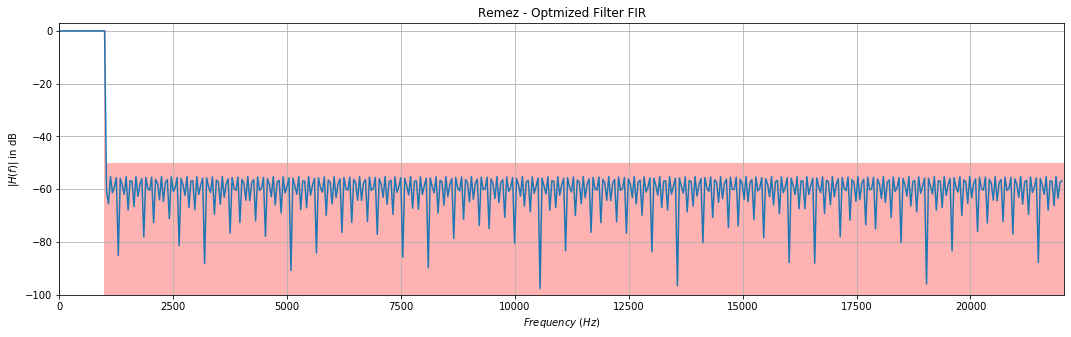

In [8]:
fs,Fs = 44.1e3, 44.1e3

fc = 1e3

Fr=np.array([0,fc-15,fc+30,Fs/2])

Att=np.array([1,-50])

numtaps, beta = signal.kaiserord(50, 10/(0.5*Fs)) # Parameter for the Kaiser function (Bessel Fucntion)

# Parameters to cutoff frequency and template
wp=Fr[1]/Fs*2.0
ws=Fr[2]/Fs*2.0
gpass=Att[0]
gstop=-Att[1]

# Filter Response
h=signal.remez(numtaps,np.array([0,fc,fc+10,fs/2])/fs,np.array([1.0,0.0]),type='bandpass')
w, H = signal.freqz(h)
    
# Plot Paremeters
axes=[0, Fs/2, -100, 3] # Axes limits
plt.figure(figsize = (18, 5)) # Plot size
plot_template(Fr, Att, Fs, axes,0,'Remez - Optmized Filter FIR')
# Plot the Frequency Response of this filter x Frequency 
plt.plot(w/(2*np.pi)*Fs, 20*np.log10(np.abs(H)))

#### Phase Plot (Normalized)

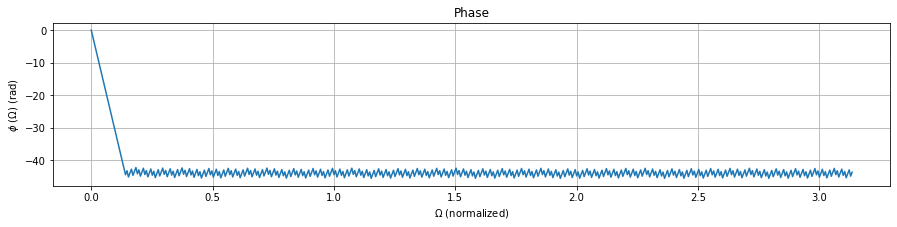

In [9]:
# tracé de la réponse fréquentielle en phase
plt.figure(figsize=(15, 3))
plt.plot(w, np.unwrap(np.angle(H)))
plt.title('Phase')
plt.xlabel('$\Omega$ (normalized)')
plt.ylabel(r'$\phi$ $(\Omega)$ (rad)')
plt.grid()

#### Zoom and Template

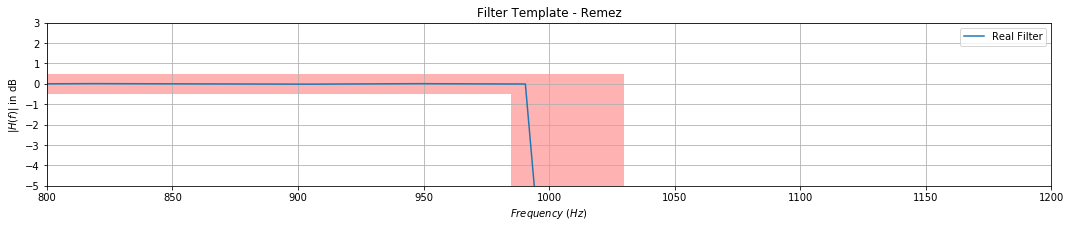

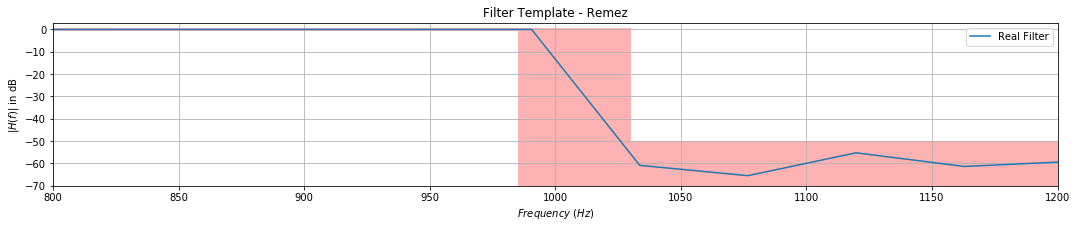

In [10]:
axes=[800, 1200, -5, 3]
plt.figure(figsize = (18, 3))
plot_template(Fr, Att, Fs, axes,0,'Filter Template - Remez')
plt.plot(w/(2*np.pi)*Fs, 20*np.log10(np.abs(H)))
plt.legend(['Real Filter'])


axes=[800, 1200, -70, 3]
plt.figure(figsize = (18, 3))
plot_template(Fr, Att, Fs, axes,0,'Filter Template - Remez')
plt.plot(w/(2*np.pi)*Fs, 20*np.log10(np.abs(H)))
plt.legend(['Real Filter'])


#### Elapsed Time

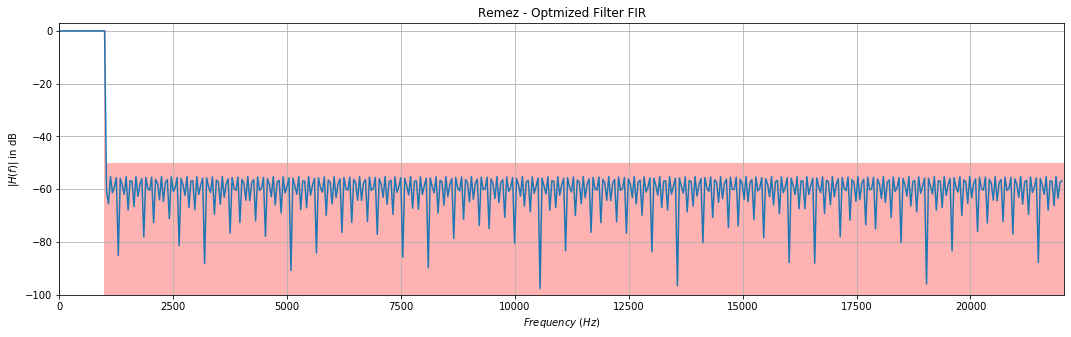

In [11]:
import timeit

code_to_test = """
# ---------------------------
# Importer les bibliothèques
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import matplotlib.patches as mpatches
# ---------------------------

def plot_template(Fr, Att,Fs,axes,togiir,title):
    '''
    plot_template(frequencies, attenuations, Fs)
    frequencies holds an array with the corner frequencies.  It has to start
     with 0 and terminate with Fs/2
        example : low pass Fr=np.array([0,100,110,Fs/2])

    attenuation holds an array with the corresponding attenuations
        example : low pass Att=np.array([2,-60])
                (ripple of 2 dB, Attenuation of -60 dB)
    Fs holds the sampling frequency
    axes [minx (in Hz), maxx (in Hz), min y (in dB), max y (in dB)]
            Very useful to zoom on parts of the frequency response
    togiir = 1 if you design an IIR filter (in the IIR filter, the 
                bandpass maximum gain is 0dB, so the amplitude is between
                0 and 0-ripple in dB.  For FIR filters, the mean
                attenuation is 0 dB)
    title : title of the plot
    
    Committed by L. Deneire, Nov. 20 2018
    '''
    min_y=axes[2]
    togiir=-togiir
    p=[]
        # a polygon inside which the frequency response has to live !
    tog=(Fr.size>4)
        # for internal purpose
    ftype=int(Att[0]>0)
        #ftype : 1 if it starts with low attenuation (e.g. low pass)
        #      : 0 if it starts with high attenuation (e.g. high pass)
    if (ftype==1):
        for i in np.arange(0,Fr.size,2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i+1], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i+1], min_y]]
           else:
                p=p+[[Fr[i-1], min_y],[Fr[min(i+1+int(tog),Fr.size-1)], min_y]]
        for i in np.arange(Fr.size-2,-1,-2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i+1], Att[i//2]/2+Att[i//2]/2*togiir],[Fr[max(0,i-1)], Att[i//2]/2+Att[i//2]/2*togiir]]
           else:     
                p=p+[[Fr[i+1], Att[i//2]],[Fr[i], Att[i//2]],[Fr[i], Att[i//2-1]/2+Att[i//2-1]/2*togiir]]
    else:
        for i in np.arange(0,Fr.size,2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i], Att[i//2]],[Fr[i+1], Att[i//2]],[Fr[i+1], Att[i//2]/2]]
           else:
                p=p+[[Fr[i-1], Att[i//2]/2+Att[i//2]/2*togiir],[Fr[min(i+1+int(tog),Fr.size-1)], Att[i//2]/2+Att[i//2]/2*togiir]]
        for i in np.arange(Fr.size-2,-1,-2):
           if (np.mod(i,4)==0):
                p=p+[[Fr[i+1], min_y],[Fr[max(0,i-1)], min_y]]
           else:     
                p=p+[[Fr[i+1], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i], Att[i//2]/2*togiir-Att[i//2]/2],[Fr[i], min_y]]
    polygon = mpatches.Polygon(p, closed=True, facecolor='r', alpha=0.3)
    plt.gca().add_patch(polygon)
    plt.title(title)
    plt.xlabel(r'$Frequency \ (Hz)$')
    plt.ylabel(r'$|H(f)|$ in dB')
    plt.axis(axes)
    plt.grid();

fs,Fs = 44.1e3, 44.1e3

fc = 1e3

Fr=np.array([0,fc-15,fc+30,Fs/2])

Att=np.array([1,-50])

numtaps, beta = signal.kaiserord(50, 10/(0.5*Fs)) # Parameter for the Kaiser function (Bessel Fucntion)

# Parameters to cutoff frequency and template
wp=Fr[1]/Fs*2.0
ws=Fr[2]/Fs*2.0
gpass=Att[0]
gstop=-Att[1]

# Filter Response
h=signal.remez(numtaps,np.array([0,fc,fc+10,fs/2])/fs,np.array([1.0,0.0]),type='bandpass')
w, H = signal.freqz(h)
    
# Plot Paremeters
axes=[0, Fs/2, -100, 3] # Axes limits
plt.figure(figsize = (18, 5)) # Plot size
plot_template(Fr, Att, Fs, axes,0,'Remez - Optmized Filter FIR')
# Plot the Frequency Response of this filter x Frequency 
plt.plot(w/(2*np.pi)*Fs, 20*np.log10(np.abs(H)))
"""
elapsed_time = timeit.timeit(code_to_test, number=1)/1


#### Filter Parameters

In [12]:
print('Ripple of',Att[0],'dB')
print('Attenuation of',-Att[1],'dB')
print('Filter Order:', numtaps-1)
print('Elapsed Time:', round(elapsed_time,1), 's')

Ripple of 1 dB
Attenuation of 50 dB
Filter Order: 12917
Elapsed Time: 4.6 s


- - -

<div class="solucao alert alert-success">
    - Core: 8Gb \\ Between 4 and 6 seconds \\ $filter \ order = 12917$ 
</div>

- - -

## Kaiser

    The Kaiser window yields an optimal window in the sense that the 
    side lobe ripple is minimized in the least squares sense for a 
    certain main lobe width.    
    
$$
    K_{N}[n] = \left \{
    \begin{aligned}
        &\dfrac{ l_{0} \big( \beta \sqrt{1 - (\frac{2n}{N-1})^2} \big)}{l_{0}(\beta)} , && - \dfrac{N-1}{2} \leq n \leq \dfrac{N-1}{2} \\
        &0, && \text{otherwise.}
    \end{aligned} \right.
$$

* $ l_{0}(x) $ is the modified zeroth-order Bessel function
* $\beta$ constant which controls the trade-off of the side-lobe heights and the width of the main lobe.

- - -

## IIR Filter

    They're based on transformations from analog filters:

$$ \sum_{i=0}^{N} a_i y[n-i] = \sum_{l=0}^{M}b_l x[n-l] \\
\sum_{i=0}^{N} a_i Y(z) z^{-i} = \sum_{l=0}^{M} b_l X(z) z^{-l} \Rightarrow H(z) = \dfrac{Y(z)}{X(z)} = \dfrac{ \sum_{i=0}^{N} a_i z^{-i} }{ \sum_{l=0}^{M} b_l z^{-l}}$$

* Elliptiques
* Chebyshev I
* Chebyshev II
* Butterworth

- - -
## Eliptique 
    Control both Passband and Stopband ripple 
    
* 4 parameters (2 ripple parameters, Passband Cutoff frequency and Stopband Cutoff frequency (or n)).

- - -
## Chebyshev I 
    Specifies ripple in the Pass band
    
## Chebyshev II
    Specifies ripple in the Stop band (flat in Pass band)

- - -
## Butterworth

    The Butterworth filter yields: 
    
* Flat frequency response in the Passa Band and Stop Band 
* Large transition band
* Decrease of 6 ndB / octave
* In the analog domain, for a LPF with $2n$ pairs of conjugate poles, with a cutoff frequency of $\omega_{c}$ :

$$
    | H(\omega)|^2 = \dfrac{1}{1 + \bigg( \dfrac{\omega}{\omega_{c}} \bigg)^{2n}} 
$$

- - -

## 2. Débruitage

L’objectif des filtres sera de débruiter un signal donné, dans ce cas-ci un signal audio,en utilisant une fréquence d’échantillonnage de 44100 Hz. Dans  un premier temps, vous fabriquerez trois types de bruit: un  bruit bassefréquences, un bruit passe-bande et un bruit haute fréquence. Vous pouvez choisir les bandes de fréquences qui vous paraissent raisonnables (la bande que j’ai prise dansl’exemple ci-dessous est ... très étroite). Pour la génération de ce bruit, inspirez vous du code ci-dessous. Ensuite, vous prendrez un signal audio existant, ou en fabriquerez un vous même(par exemple un chirp, qui balaie toutes les fréquences de 0 à 22050 Hz), et l’affecterez du bruit généré précédemment. Ensuite, vous concevrez les filtres permettant de débruiter le signal. Vous utiliserez les filtres FIR de Remez et de Kaiser, ainsi que les filtres IIR elliptiques, de Chebyshev I et II et de Butterworth, et les appliquerez au signal bruité. Pour chacun de ces filtres vous fournirez:

* Les spécifications de vos filtres (bandes passantes, ripple, atténuations), les gabarits correspondants et les caractéristiques du filtre (ordre, type de filtre, amplitudede la réponse fréquentielle en dB, linéarité de la phase, le diagramme zéros-pôles pour les IIR).


* Le nombre de multiplications nécessaires par seconde (tenir compte de la symétriedes FIRs).


* Discutez de la performance des filtres en étudiant le SNR après débruitage (et éventuellement sur base de votre écoute des signaux). En fonctions de ces résultats, donnez des recommandations pour le débruitage design aux audio

- - -

<div class="solucao alert alert-success">
Reading: 'piano.wav' and the sampling frequency.
</div>

- - -

In [13]:
sr, piano = wavfile.read('piano.wav');
ipd.Audio(piano,rate=sr)

#### Sampling Rate 

In [14]:
print('Quantity of n samples per seconds:', sr)

Quantity of n samples per seconds: 44100


- - -

<div class="solucao alert alert-success">
It means the sampling frequency is 44.1 kHz.
</div>

- - -

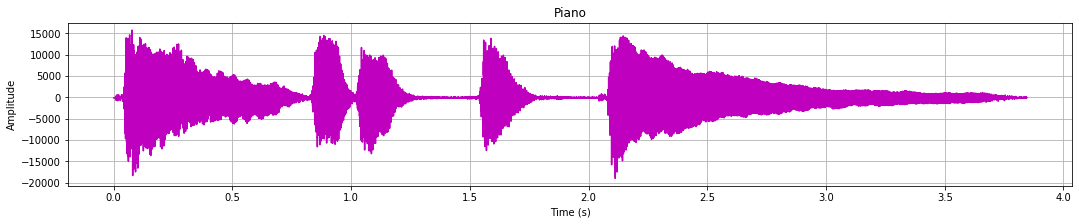

In [15]:
N = len(piano);
time = linspace(0, N/sr, N);
myplot(time, piano, title='Piano',x_axis='Time (s)', y_axis='Amplitude')

#### Center and Scale
    Normalization to work with the signal 'piano' with zero mean and amplitude limited between [-0.5, 0.5].
    
$$
y' = \dfrac{y - \mu(y)}{\sigma(y)} \\
y'' = 0.5 \dfrac{y'}{max(|y'|)}
$$



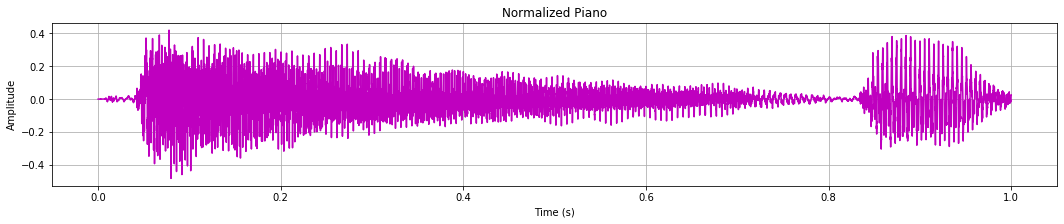

In [16]:
y=(piano - np.mean(piano))/ (np.std(piano)); 
y = y/(2*max(abs(y)));

# Take the signal until 1s
y = y[0:sr];
time = time[0:sr];

myplot(time, y, title='Normalized Piano',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y,rate=sr)

#### Power of the Signal
    Calcultate the power of two for the vector norm.
    
$$
P_{y} = \| y \| ^ 2 \rightarrow P_{y_{dB}} = 10 \log_{10} (P_{y}) \\
P_{y_{dB}} = 20 \log_{10} (\| y \|)
$$

In [17]:
Py=norm(y)**2
Py_dB = 10*log10(Py)
print('Power of the signal:', round(Py_dB,1), 'dB')

Power of the signal: 25.8 dB


## White Noise

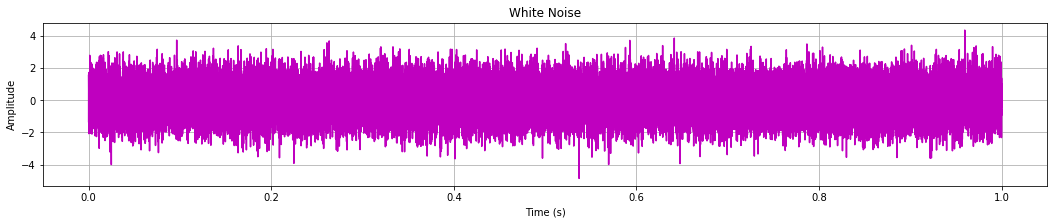

In [18]:
noise=np.random.normal(0,1,np.size(y)) # filter it between 220 and 250 Hz 

myplot(time, noise, title='White Noise',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(noise,rate=sr)

#### Power of the Noise

In [19]:
Pnoise_dB = 20*log10(norm(noise))
print('Power of the signal:', round(Pnoise_dB,1), 'dB')

Power of the signal: 46.4 dB


# Low Pass Filter

#### Preparing the Noise -  Remez Filter (Low Pass Filter: 0 - 880 Hz)

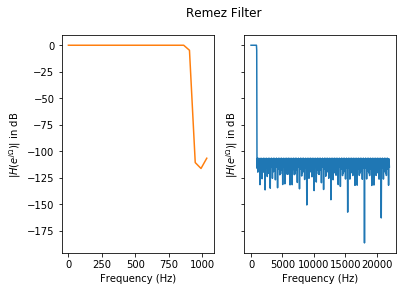

In [20]:
fc1, fc2 = 880, 910;

firnoise=signal.remez(5501,np.array([0,880,932,sr/2])/sr,np.array([1.0,0.0]),type='bandpass')

# plot the response of the filter
w, Hk = signal.freqz(firnoise,1)

fig, axs = plt.subplots(1, 2, sharex='col', sharey='row',
                        gridspec_kw={'hspace': .1, 'wspace': .2})
(ax1, ax2) = axs
fig.suptitle('Remez Filter')
ax1.plot(w[0:25]/(2*np.pi)*sr, 20*np.log10(np.abs(Hk[0:25])), 'tab:orange')
ax2.plot(w/(2*np.pi)*sr, 20*np.log10(np.abs(Hk)))

for ax in axs.flat:
    ax.label_outer()
    ax.set(xlabel='Frequency (Hz)', ylabel='$|H(e^{j \Omega})|$ in dB')

- - -

In [21]:
# actually filter the noise 
filtered_noise = np.convolve(firnoise,noise) 

# add the noise to the signal (take group delay into account)
ynoisy=y+filtered_noise[2750:y.size+2750:]

- - -

#### Denoising -  Remez Filter (Cutoff: 0-880 Hz)

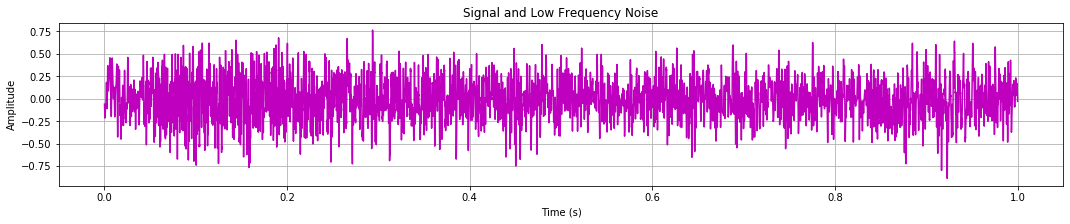

In [22]:
myplot(time, ynoisy, title='Signal and Low Frequency Noise',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(ynoisy,rate=sr)

- - -

<div class="solucao alert alert-success">
$Remez$
</div>

- - -

#### Filter Design

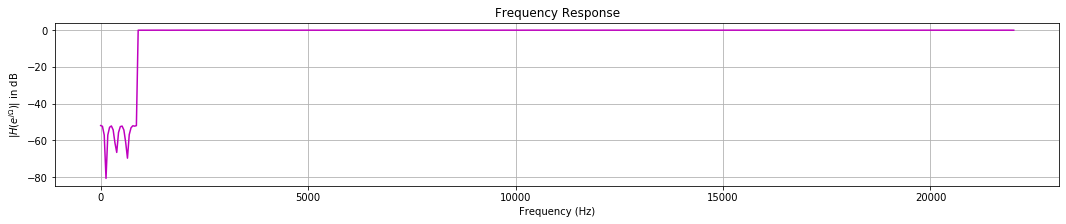

In [23]:
# design (crudely) the denoising filter 
ripple = 10; width = 1.05/(sr/2); numstaps, beta = signal.kaiserord(ripple, width);
LPF_remez=signal.remez(numstaps,np.array([0,fc1, 0.9*fc,sr/2])/sr,np.array([0.0,1.0]),type='bandpass')

# actually filter the noise 
y_LPF_remez_denoised = np.convolve(LPF_remez,ynoisy)

# (take group delay into account)
y_LPF_remez_denoised = y_LPF_remez_denoised[2750:y.size+2750:]
    
# Plot
w_LPF_remez, H_LPF_remez = signal.freqz(LPF_remez)
myplot(w_LPF_remez/(2*np.pi)*sr, 20*np.log10(np.abs(H_LPF_remez)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

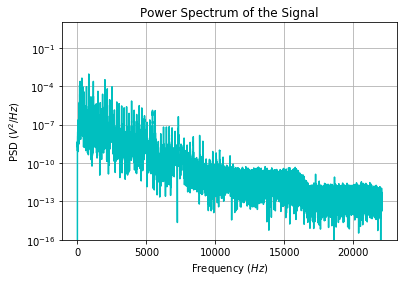

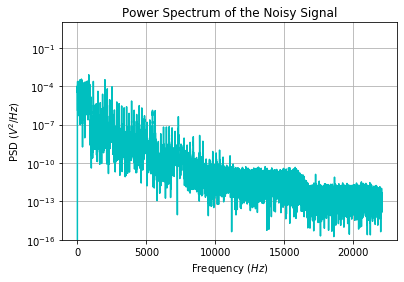

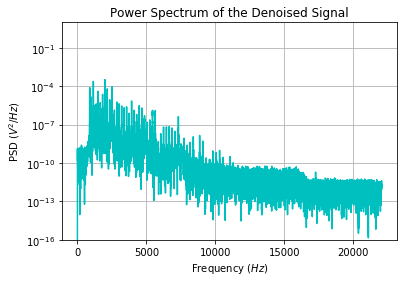

Power of y =  25.820541327492048 dB
SNR before denoising =  -6.690430338640615 dB
SNR after denoising =  -1.8609125927444223 dB


In [24]:
SNR_LPF_remez = myspectre(sr, y, ynoisy, y_LPF_remez_denoised)

#### Denoised Signal

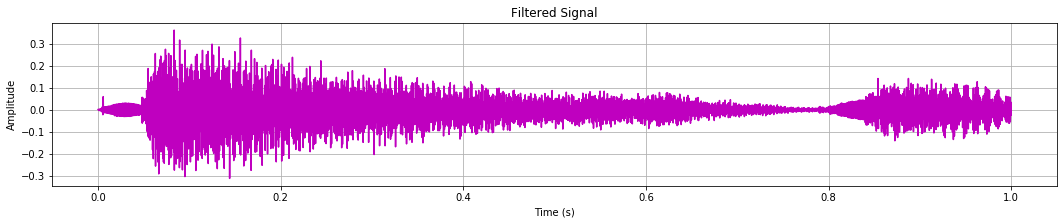

In [25]:
myplot(time, y_LPF_remez_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_LPF_remez_denoised,rate=sr)

- - -

- - -

<div class="solucao alert alert-success">
$Kaiser$
</div>

- - -

#### Filter Design

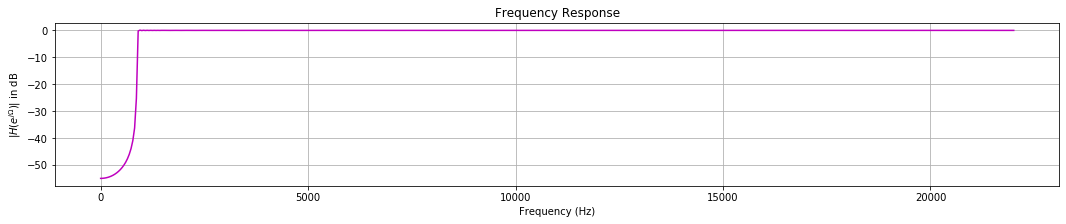

In [26]:
# design (crudely) the denoising filter 
ripple = 9; width = 1.05/(sr/2); numstaps, beta = signal.kaiserord(ripple, width);
LPF_kaiser = signal.firwin(numstaps, fc1, window=('kaiser', beta),
                                        pass_zero=False,scale=False, nyq=fs/2)

# actually filter the noise 
y_LPF_kaiser_denoised = np.convolve(LPF_kaiser,ynoisy)

# (take group delay into account)
y_LPF_kaiser_denoised = y_LPF_kaiser_denoised[2750:y.size+2750:]
    
# Plot
w_LPF_kaiser, H_LPF_kaiser = signal.freqz(LPF_kaiser)
myplot(w_LPF_kaiser/(2*np.pi)*sr, 20*np.log10(np.abs(H_LPF_kaiser)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

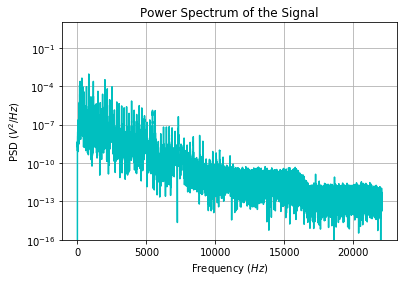

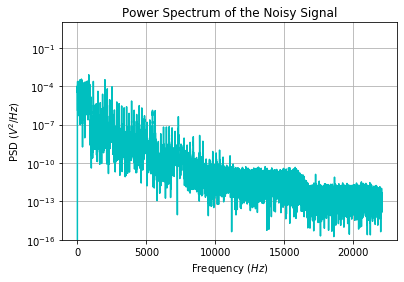

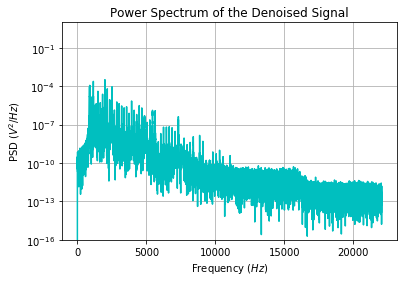

Power of y =  25.820541327492048 dB
SNR before denoising =  -6.690430338640615 dB
SNR after denoising =  -0.3645052097417052 dB


In [27]:
SNR_LPF_kaiser = myspectre(sr, y, ynoisy, y_LPF_kaiser_denoised)

#### Denoised Signal

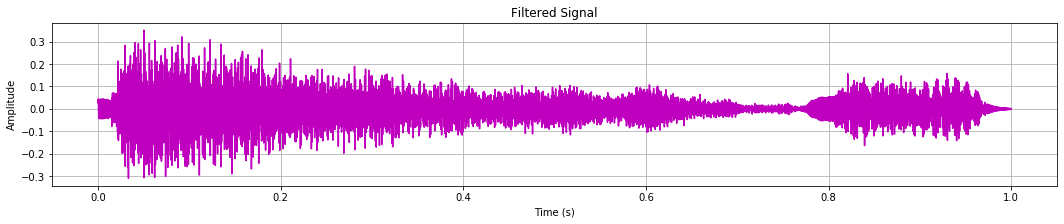

In [28]:
myplot(time, y_LPF_kaiser_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_LPF_kaiser_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Elliptic$
</div>

- - -

#### Filter Design

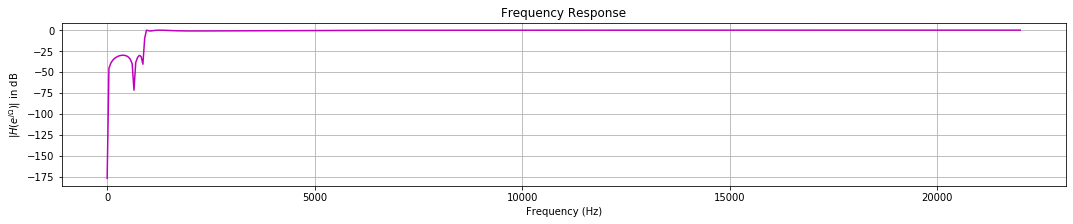

In [29]:
# design (crudely) the denoising filter 
#fc1, fc2 = 880, 910 # cutoff frequency
wp, ws = fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 30 # parameters ripple and attenuation

b_LPF_elliptic, a_LPF_elliptic = signal.iirdesign(wp, ws, gpass, gstop, ftype='ellip')

# actually filter the noise 
y_LPF_elliptic_denoised = signal.filtfilt(b_LPF_elliptic,a_LPF_elliptic, ynoisy)
    
# Plot
w_LPF_elliptic, H_LPF_elliptic = signal.freqz(b_LPF_elliptic, a_LPF_elliptic)
myplot(w_LPF_elliptic/(2*np.pi)*sr, 20*np.log10(np.abs(H_LPF_elliptic)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

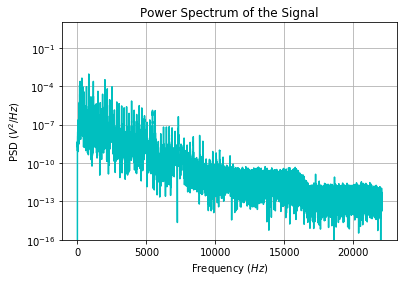

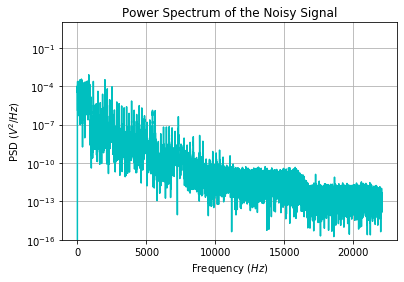

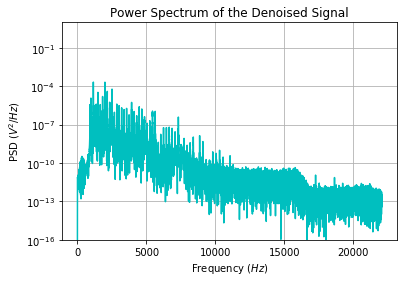

Power of y =  25.820541327492048 dB
SNR before denoising =  -6.690430338640615 dB
SNR after denoising =  1.4741905918748417 dB


In [30]:
SNR_LPF_elliptic = myspectre(sr, y, ynoisy, y_LPF_elliptic_denoised)

#### Poles and Zeros Diagram

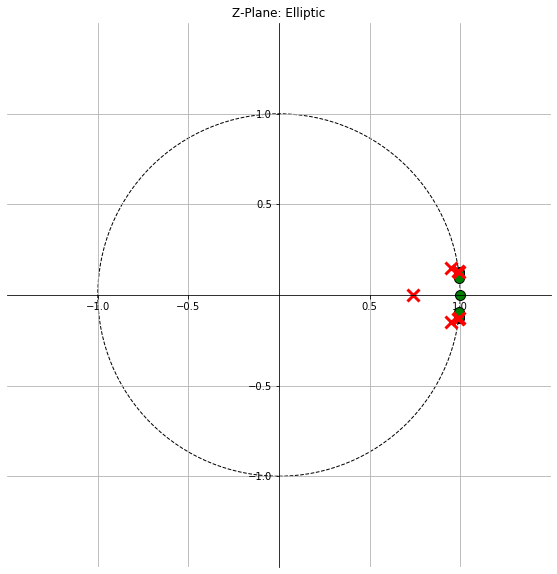

In [31]:
zplane(b_LPF_elliptic, a_LPF_elliptic, title='Z-Plane: Elliptic')

#### Denoised Signal

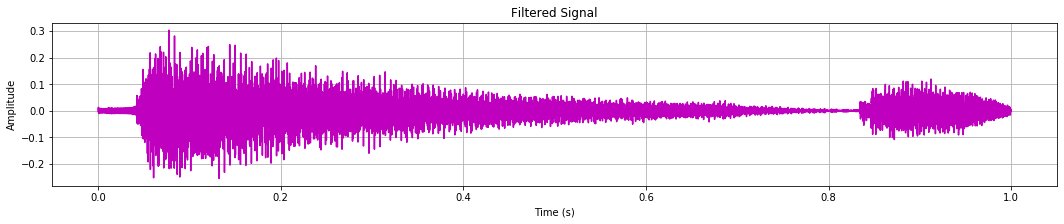

In [32]:
myplot(time, y_LPF_elliptic_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_LPF_elliptic_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Cheby1$
</div>

- - -

#### Filter Design

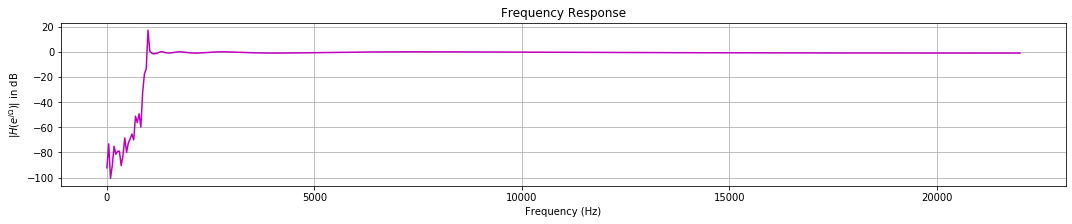

In [33]:
# design (crudely) the denoising filter 
#fc1, fc2 = 880, 910 # cutoff frequency

# Adaptation band width - to the cutoff frequency
wp, ws = 1.025*fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 30 # parameters ripple and attenuation

b_LPF_cheby1, a_LPF_cheby1 = signal.iirdesign(wp, ws, gpass, gstop, ftype='cheby1')

# actually filter the noise 
y_LPF_cheby1_denoised = signal.filtfilt(b_LPF_cheby1,a_LPF_cheby1, ynoisy)
    
# Plot
w_LPF_cheby1, H_LPF_cheby1 = signal.freqz(b_LPF_cheby1, a_LPF_cheby1)
myplot(w_LPF_cheby1/(2*np.pi)*sr, 20*np.log10(np.abs(H_LPF_cheby1)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

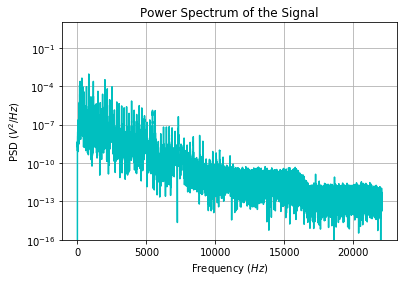

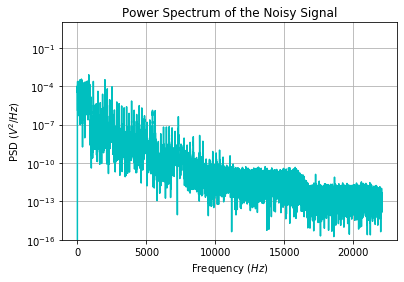

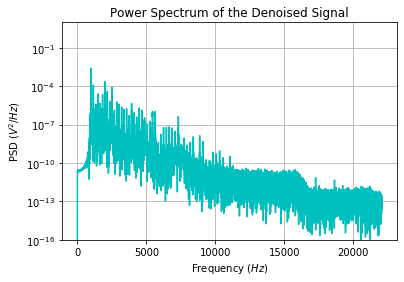

Power of y =  25.820541327492048 dB
SNR before denoising =  -6.690430338640615 dB
SNR after denoising =  -3.0687312914020826 dB


In [34]:
SNR_LPF_cheby1 = myspectre(sr, y, ynoisy, y_LPF_cheby1_denoised)

#### Poles and Zeros Diagram

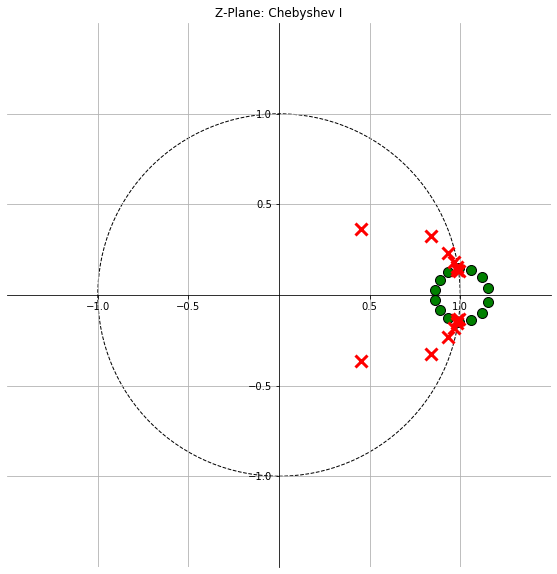

In [35]:
zplane(b_LPF_cheby1,a_LPF_cheby1, title='Z-Plane: Chebyshev I')

#### Denoised Signal

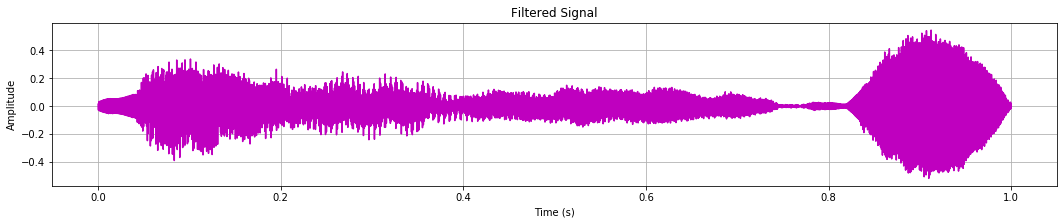

In [36]:
myplot(time, y_LPF_cheby1_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_LPF_cheby1_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Cheby2$
</div>

- - -

#### Filter Design

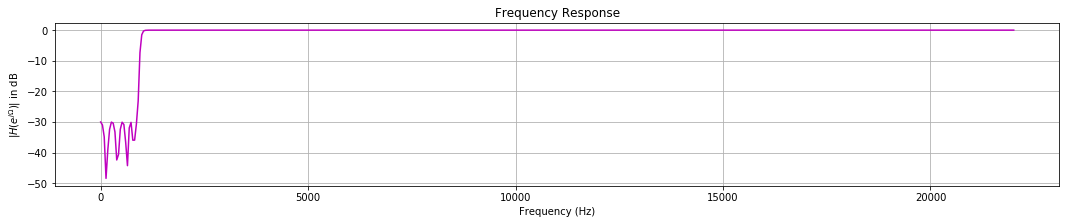

In [37]:
# design (crudely) the denoising filter 
# Adaptation band width - to the cutoff frequency
wp, ws = 1.1*fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 30 # parameters ripple and attenuation

b_LPF_cheby2, a_LPF_cheby2 = signal.iirdesign(wp, ws, gpass, gstop, ftype='cheby2')

# actually filter the noise 
y_LPF_cheby2_denoised = signal.filtfilt(b_LPF_cheby2,a_LPF_cheby2, ynoisy)
    
# Plot
w_LPF_cheby2, H_LPF_cheby2 = signal.freqz(b_LPF_cheby2, a_LPF_cheby2)
myplot(w_LPF_cheby2/(2*np.pi)*sr, 20*np.log10(np.abs(H_LPF_cheby2)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

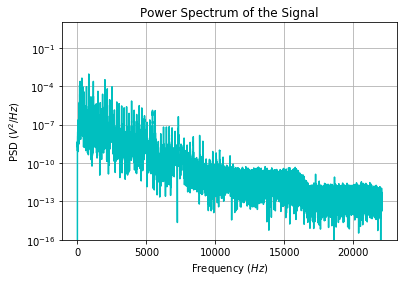

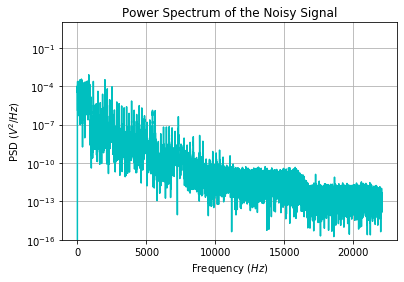

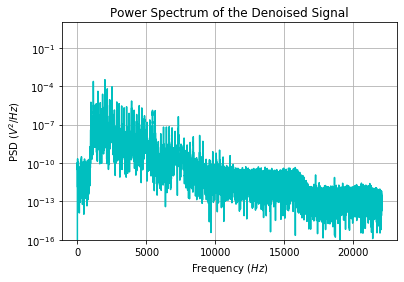

Power of y =  25.820541327492048 dB
SNR before denoising =  -6.690430338640615 dB
SNR after denoising =  1.51435860812231 dB


In [38]:
SNR_LPF_cheby2 = myspectre(sr, y, ynoisy, y_LPF_cheby2_denoised)

#### Poles and Zeros Diagram

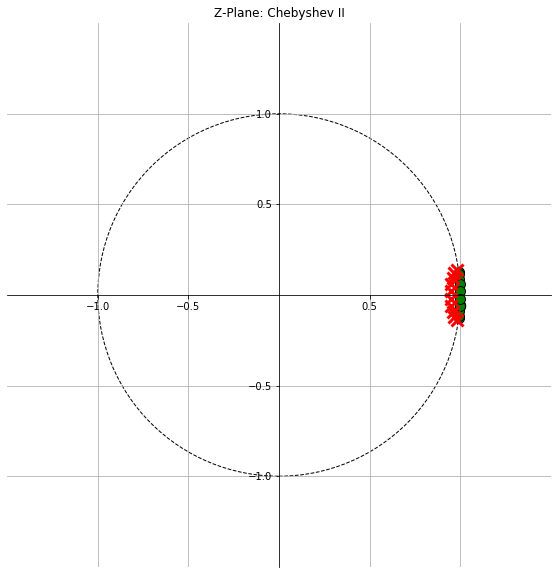

In [39]:
zplane(b_LPF_cheby2,a_LPF_cheby2, title='Z-Plane: Chebyshev II')

#### Denoised Signal

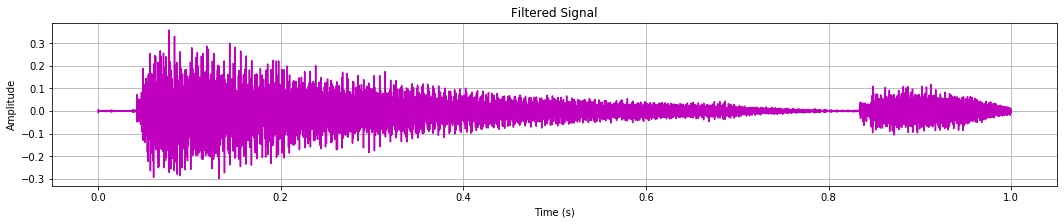

In [40]:
myplot(time, y_LPF_cheby2_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_LPF_cheby2_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Butterworth$
</div>

- - -

#### Filter Design

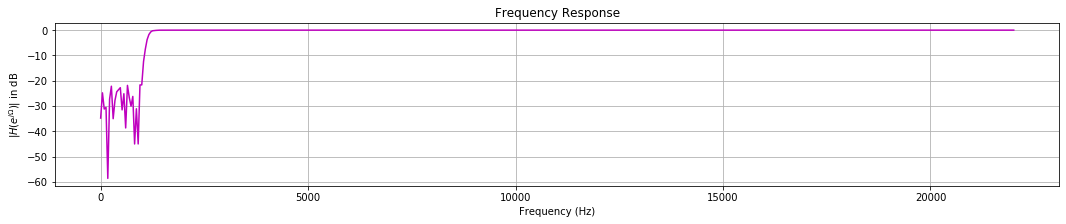

In [41]:
# design (crudely) the denoising filter 
# Adaptation band width - to the cutoff frequency
wp, ws = 1.3*fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 30 # parameters ripple and attenuation

b_LPF_butter, a_LPF_butter = signal.iirdesign(wp, ws, gpass, gstop, ftype='butter')

# actually filter the noise 
y_LPF_butter_denoised = signal.filtfilt(b_LPF_butter,a_LPF_butter, ynoisy)
    
# Plot
w_LPF_butter, H_LPF_butter = signal.freqz(b_LPF_butter, a_LPF_butter)
myplot(w_LPF_butter/(2*np.pi)*sr, 20*np.log10(np.abs(H_LPF_butter)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

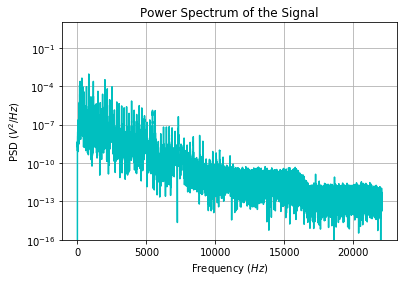

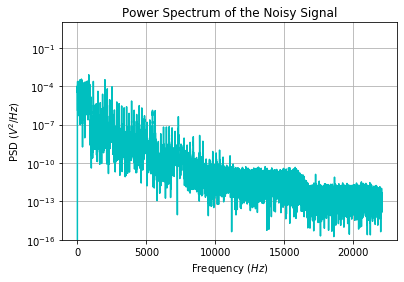

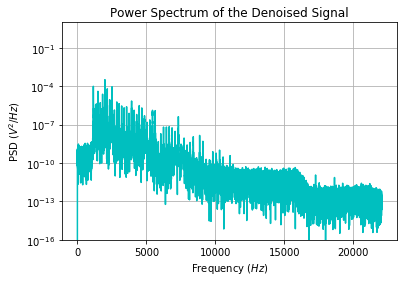

Power of y =  25.820541327492048 dB
SNR before denoising =  -6.690430338640615 dB
SNR after denoising =  1.3921282893218367 dB


In [42]:
SNR_LPF_butter = myspectre(sr, y, ynoisy, y_LPF_butter_denoised)

#### Denoised Signal

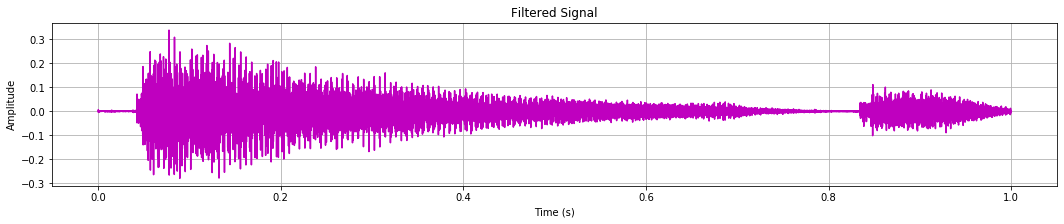

In [43]:
myplot(time, y_LPF_butter_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_LPF_butter_denoised,rate=sr)

- - -

# Pass Band Filter

#### Preparing the Noise -  Remez Filter (Pass Band Filter: 4000 - 4030 Hz)

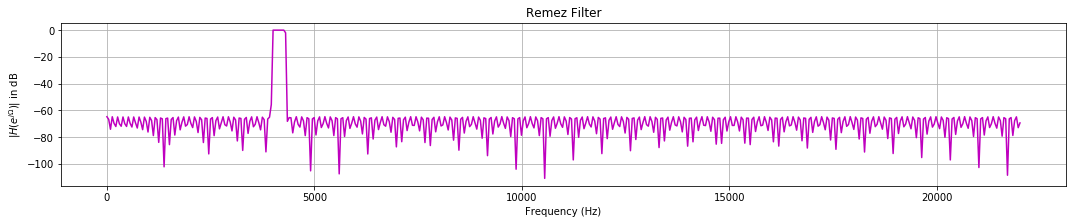

In [44]:
# design (crudely) the denoising filter 
ripple, width = 10, 0.8/(sr/2); numstaps, beta = signal.kaiserord(ripple, width)
fc1, fc2 = 4000, 4300; edges = np.array([0, fc1 - 20, fc1, fc2, fc2 + 20, fs/2]) # the cutoff frequency

# design (crudely) the denoising filter 
firnoise = signal.remez(numstaps,edges/sr,[0.0,1.0,0.0],type='bandpass')

# plot the response of the filter
w, Hk = signal.freqz(firnoise,1)

myplot(w/(2*np.pi)*sr, 20*np.log10(np.abs(Hk)), 
       title='Remez Filter',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

In [45]:
# actually filter the noise 
filtered_noise = np.convolve(firnoise,noise) 

# add the noise to the signal (take group delay into account)
ynoisy=y+filtered_noise[2750:y.size+2750:]

#### Denoising -  Remez Filter (Cutoff: 4000 - 6000 Hz)

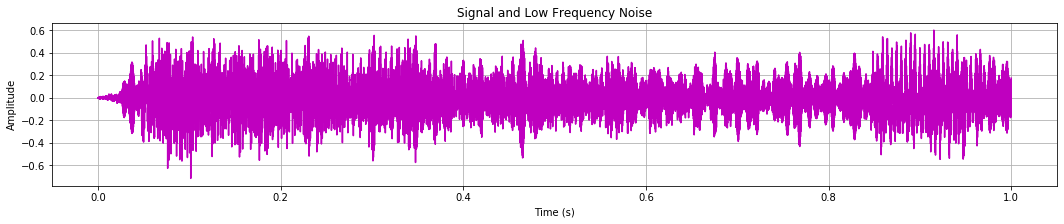

In [46]:
myplot(time, ynoisy, title='Signal and Low Frequency Noise',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(ynoisy,rate=sr)

- - -

<div class="solucao alert alert-success">
$Remez$
</div>

- - -

#### Filter Design

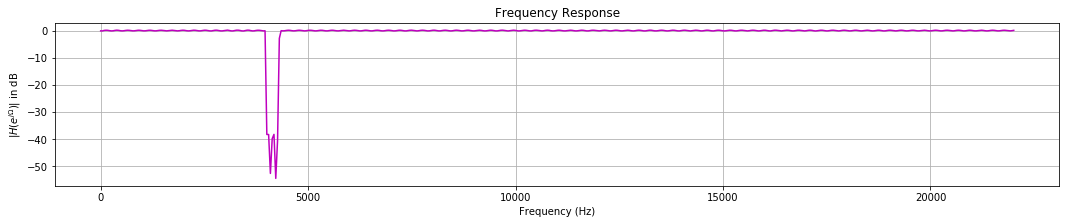

In [47]:
# design (crudely) the denoising filter 
ripple, width = 10, 0.8/(sr/2); numstaps, beta = signal.kaiserord(ripple, width)
edges = np.array([0, fc1 - 10, fc1, fc2, fc2 + 10, fs/2]) # the cutoff frequency
# design (crudely) the denoising filter 
BPF_remez = signal.remez(numstaps,edges/sr,[1.0,0.0,1.0],type='bandpass')

# actually filter the noise 
y_BPF_remez_denoised = np.convolve(BPF_remez,ynoisy)

# (take group delay into account)
y_BPF_remez_denoised = y_BPF_remez_denoised[2750:y.size+2750:]

# plot the response of the filter
w_BPF_remez, H_BPF_remez = signal.freqz(BPF_remez)

# Plot
myplot(w_BPF_remez/(2*np.pi)*sr, 20*np.log10(np.abs(H_BPF_remez)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

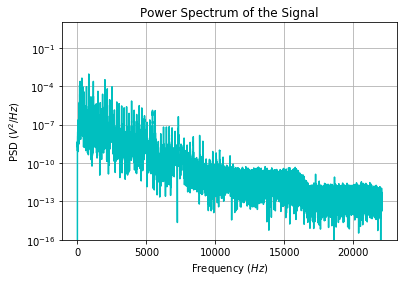

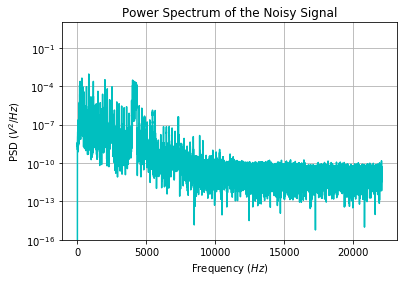

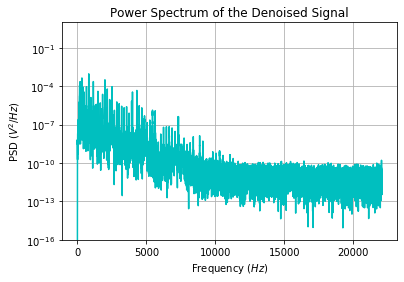

Power of y =  25.820541327492048 dB
SNR before denoising =  -2.0207271994336553 dB
SNR after denoising =  -3.1591376282899715 dB


In [48]:
SNR_BPF_remez = myspectre(sr, y, ynoisy, y_BPF_remez_denoised)

#### Denoised Signal

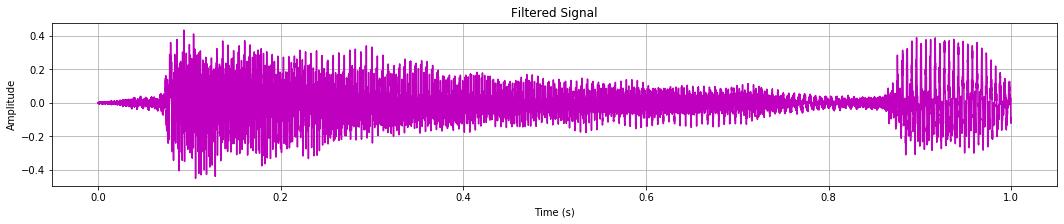

In [49]:
myplot(time, y_BPF_remez_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_BPF_remez_denoised,rate=sr)

- - -

- - -

<div class="solucao alert alert-success">
$Kaiser$
</div>

- - -

#### Filter Design

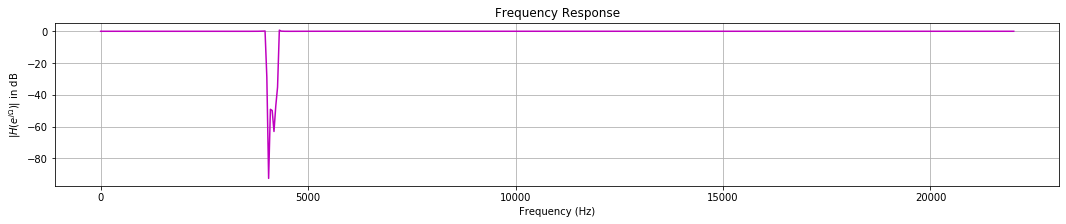

In [50]:
# design (crudely) the denoising filter 
ripple = 10; width = 1.05/(sr/2); numstaps, beta = signal.kaiserord(ripple, width);
BPF_kaiser = signal.firwin(numstaps, [fc1, fc2], window=('kaiser', beta),
                                        pass_zero=True,scale=False, nyq=fs/2)

# actually filter the noise 
y_BPF_kaiser_denoised = np.convolve(BPF_kaiser,ynoisy)

# (take group delay into account)
y_BPF_kaiser_denoised = y_BPF_kaiser_denoised[2750:y.size+2750:]
    
# Plot
w_BPF_kaiser, H_BPF_kaiser = signal.freqz(BPF_kaiser)
myplot(w_BPF_kaiser/(2*np.pi)*sr, 20*np.log10(np.abs(H_BPF_kaiser)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

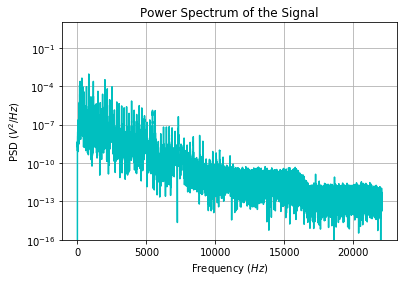

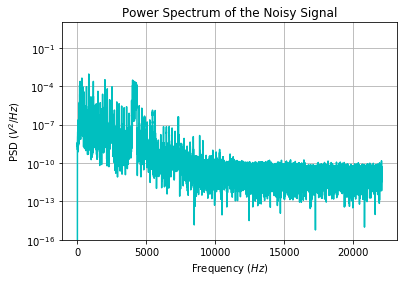

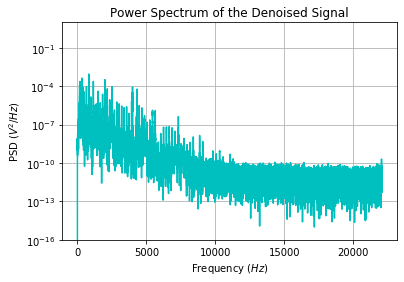

Power of y =  25.820541327492048 dB
SNR before denoising =  -2.0207271994336553 dB
SNR after denoising =  -2.9533319937868914 dB


In [51]:
SNR_BPF_kaiser = myspectre(sr, y, ynoisy, y_BPF_kaiser_denoised)

#### Denoised Signal

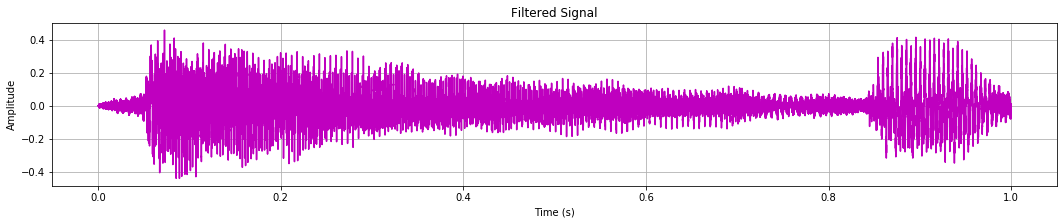

In [52]:
myplot(time, y_BPF_kaiser_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_BPF_kaiser_denoised,rate=sr)

- - -

- - -

<div class="solucao alert alert-success">
$Elliptic$
</div>

- - -

#### Filter Design

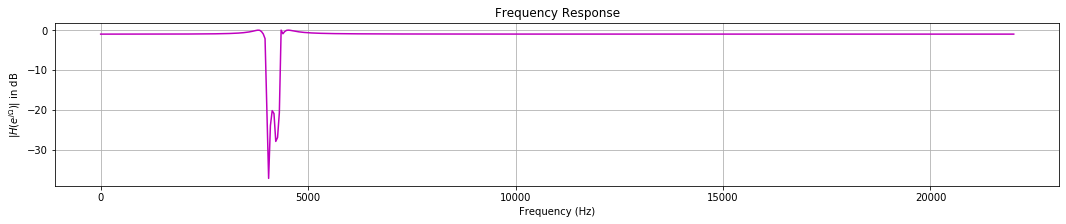

In [53]:
# design (crudely) the denoising filter 
#fc1, fc2 = 4000, 6000 # cutoff frequency
wp, ws = fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 20 # parameters ripple and attenuation

b_BPF_elliptic, a_BPF_elliptic = signal.iirdesign([0.99*ws, 1.01*wp],[ws, wp], 
                                                  gpass, gstop, ftype='ellip')
 
# actually filter the noise 
y_BPF_elliptic_denoised = signal.filtfilt(b_BPF_elliptic,a_BPF_elliptic, ynoisy)
    
# Plot
w_BPF_elliptic, H_BPF_elliptic = signal.freqz(b_BPF_elliptic, a_BPF_elliptic)
myplot(w_BPF_elliptic/(2*np.pi)*sr, 20*np.log10(np.abs(H_BPF_elliptic)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

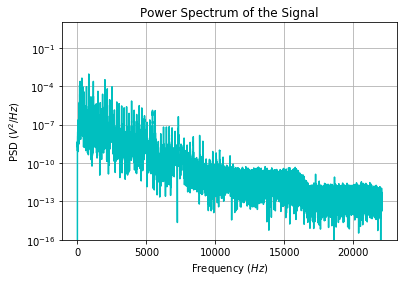

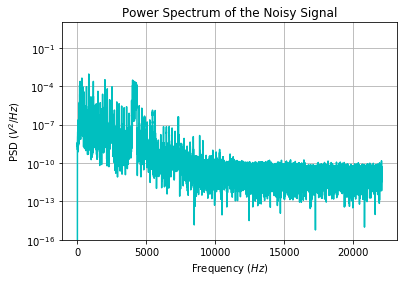

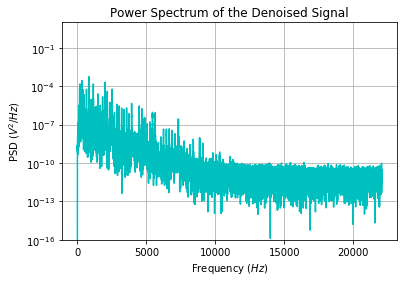

Power of y =  25.820541327492048 dB
SNR before denoising =  -2.0207271994336553 dB
SNR after denoising =  13.669951742883073 dB


In [54]:
SNR_BPF_elliptic = myspectre(sr, y, ynoisy, y_BPF_elliptic_denoised)

#### Poles and Zeros Diagram

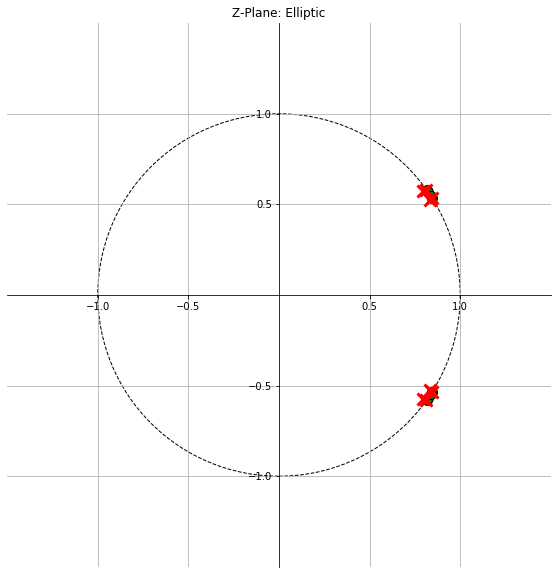

In [55]:
zplane(b_BPF_elliptic, a_BPF_elliptic, title='Z-Plane: Elliptic')

#### Denoised Signal

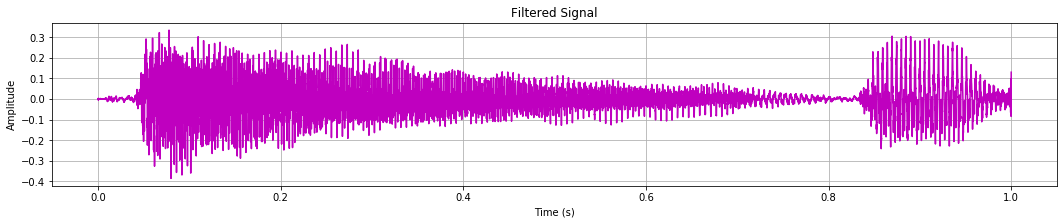

In [56]:
myplot(time, y_BPF_elliptic_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_BPF_elliptic_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Cheby1$
</div>

- - -

#### Filter Design

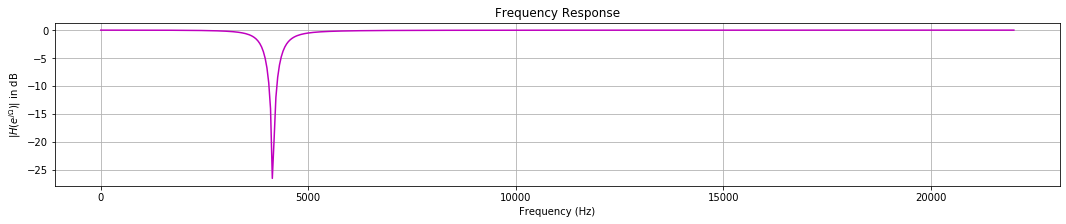

In [57]:
# design (crudely) the denoising filter 
# Adaptation band width - to the cutoff frequency
wp, ws = fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 3 # parameters ripple and attenuation

b_BPF_cheby1, a_BPF_cheby1 = signal.iirdesign([0.9*ws, 1.1*wp],[ws, wp], 
                                              gpass, gstop, ftype='cheby1')

# actually filter the noise 
y_BPF_cheby1_denoised = signal.filtfilt(b_BPF_cheby1,a_BPF_cheby1, ynoisy)
    
# Plot
w_BPF_cheby1, H_BPF_cheby1 = signal.freqz(b_BPF_cheby1, a_BPF_cheby1)
myplot(w_LPF_cheby1/(2*np.pi)*sr, 20*np.log10(np.abs(H_BPF_cheby1)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

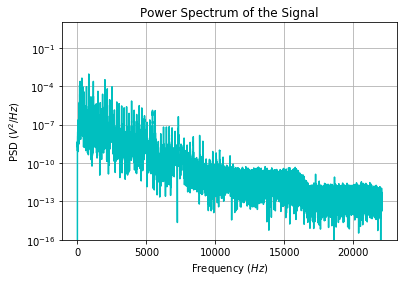

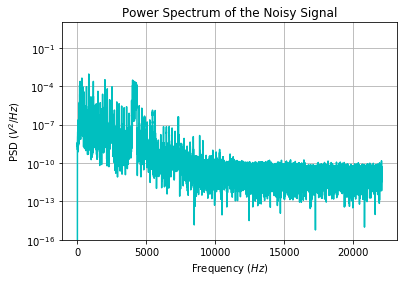

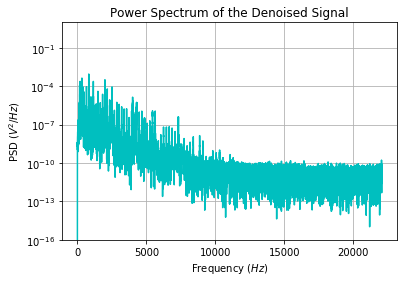

Power of y =  25.820541327492048 dB
SNR before denoising =  -2.0207271994336553 dB
SNR after denoising =  15.909445655458658 dB


In [58]:
SNR_BPF_cheby1 = myspectre(sr, y, ynoisy, y_BPF_cheby1_denoised)

#### Poles and Zeros Diagram

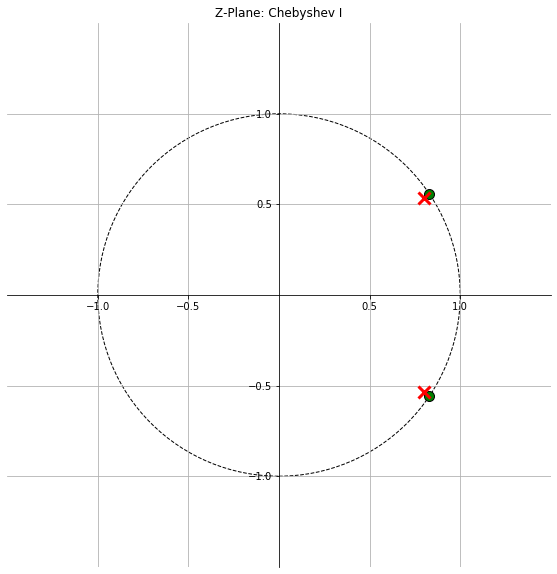

In [59]:
zplane(b_BPF_cheby1,a_BPF_cheby1, title='Z-Plane: Chebyshev I')

#### Denoised Signal

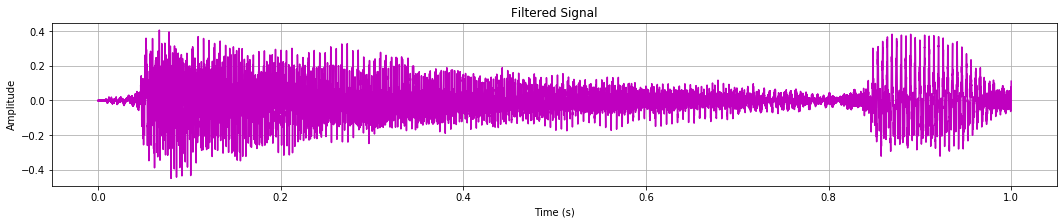

In [60]:
myplot(time, y_BPF_cheby1_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_BPF_cheby1_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Cheby2$
</div>

- - -

#### Filter Design

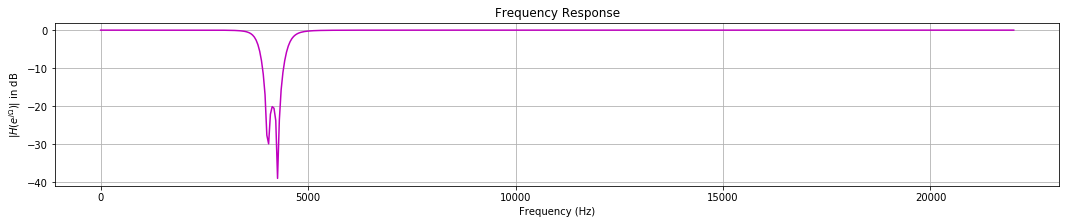

In [61]:
# design (crudely) the denoising filter 
# Adaptation band width - to the cutoff frequency
wp, ws = fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 20 # parameters ripple and attenuation

b_BPF_cheby2, a_BPF_cheby2 = signal.iirdesign([0.9*ws, 1.1*wp],[ws, wp], 
                                              gpass, gstop, ftype='cheby2')

# actually filter the noise 
y_BPF_cheby2_denoised = signal.filtfilt(b_BPF_cheby2,a_BPF_cheby2, ynoisy)
    
# Plot
w_BPF_cheby2, H_BPF_cheby2 = signal.freqz(b_BPF_cheby2, a_BPF_cheby2)
myplot(w_LPF_cheby2/(2*np.pi)*sr, 20*np.log10(np.abs(H_BPF_cheby2)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

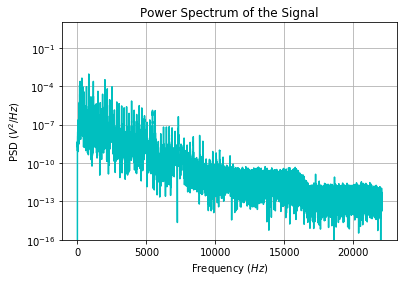

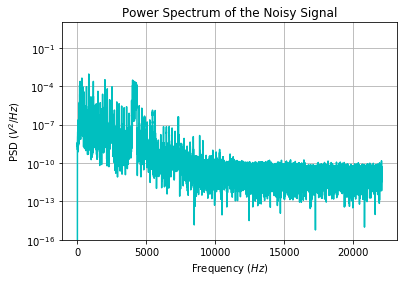

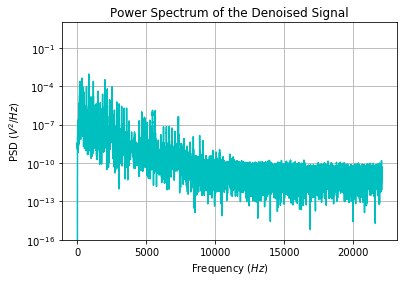

Power of y =  25.820541327492048 dB
SNR before denoising =  -2.0207271994336553 dB
SNR after denoising =  23.15838619127487 dB


In [62]:
SNR_BPF_cheby2 = myspectre(sr, y, ynoisy, y_BPF_cheby2_denoised)

#### Poles and Zeros Diagram

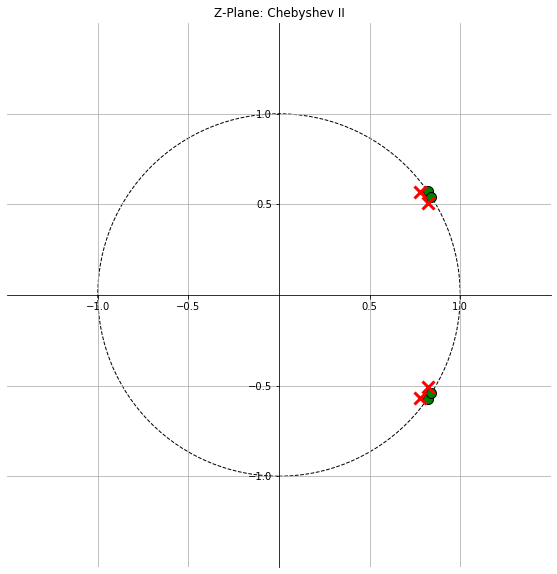

In [63]:
zplane(b_BPF_cheby2,a_BPF_cheby2, title='Z-Plane: Chebyshev II')

#### Denoised Signal

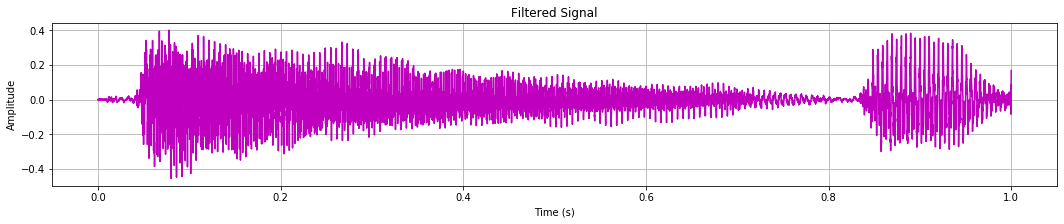

In [64]:
myplot(time, y_BPF_cheby2_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_BPF_cheby2_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Butterworth$
</div>

- - -

#### Filter Design

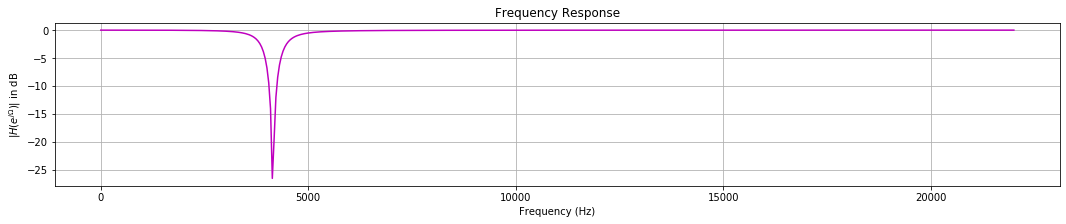

In [65]:
# design (crudely) the denoising filter 
# Adaptation band width - to the cutoff frequency
wp, ws = fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 3 # parameters ripple and attenuation

b_BPF_butter, a_BPF_butter = signal.iirdesign([0.1*ws, 1.1*wp],[ws, wp], 
                                              gpass, gstop, ftype='butter')

# actually filter the noise 
y_BPF_butter_denoised = signal.filtfilt(b_BPF_butter,a_BPF_butter, ynoisy)
    
# Plot
w_BPF_butter, H_BPF_butter = signal.freqz(b_BPF_butter, a_BPF_butter)
myplot(w_LPF_butter/(2*np.pi)*sr, 20*np.log10(np.abs(H_BPF_butter)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

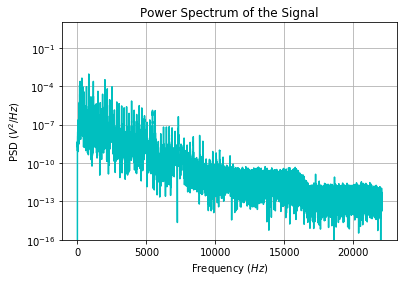

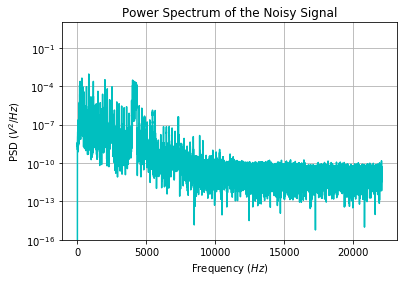

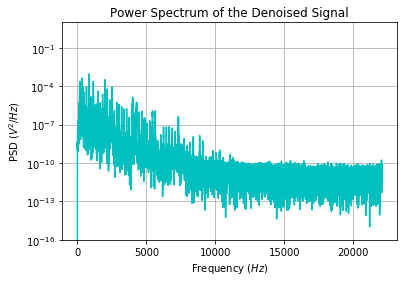

Power of y =  25.820541327492048 dB
SNR before denoising =  -2.0207271994336553 dB
SNR after denoising =  15.909804376600727 dB


In [66]:
SNR_BPF_butter = myspectre(sr, y, ynoisy, y_BPF_butter_denoised)

#### Poles and Zeros Diagram

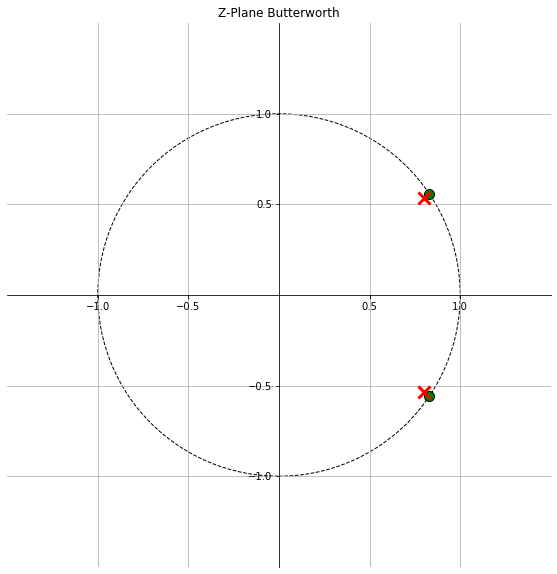

In [67]:
zplane(b_BPF_butter, a_BPF_butter, title='Z-Plane Butterworth')

#### Denoised Signal

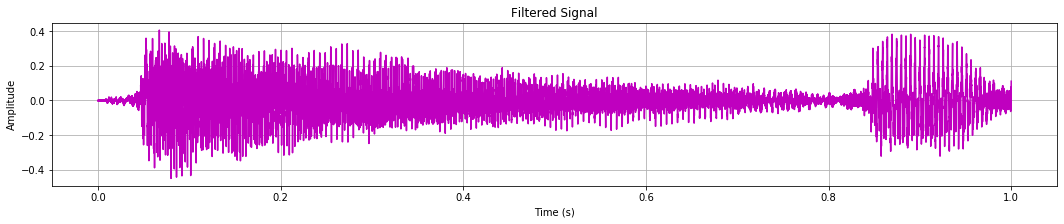

In [68]:
myplot(time, y_BPF_butter_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_BPF_butter_denoised,rate=sr)

- - -

# High Pass Filter

- - -

## Remez HPF

#### Preparing the Noise -  Remez Filter (High Band Filter: 20.05 - 22.05 Hz)

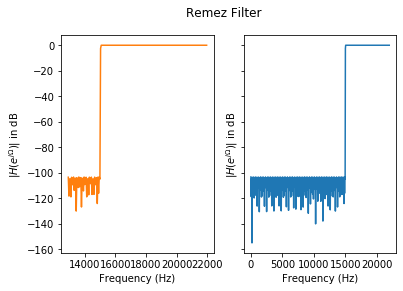

In [69]:
fc1, fc2 = 15000, 15050;

firnoise=signal.remez(5501,np.array([0,fc1,fc2,sr/2])/sr,np.array([0.0,1.0]),type='bandpass')

# plot the response of the filter
w, Hk = signal.freqz(firnoise,1)

fig, axs = plt.subplots(1, 2, sharex='col', sharey='row',
                        gridspec_kw={'hspace': .1, 'wspace': .2})
(ax1, ax2) = axs
fig.suptitle('Remez Filter')
ax1.plot(w[300:-1]/(2*np.pi)*sr, 20*np.log10(np.abs(Hk[300:-1])), 'tab:orange')
ax2.plot(w/(2*np.pi)*sr, 20*np.log10(np.abs(Hk)))

for ax in axs.flat:
    ax.label_outer()
    ax.set(xlabel='Frequency (Hz)', ylabel='$|H(e^{j \Omega})|$ in dB')

- - -

In [70]:
# actually filter the noise 
filtered_noise = np.convolve(firnoise,noise) 

# add the noise to the signal (take group delay into account)
ynoisy=y+filtered_noise[2750:y.size+2750:]

#### Denoising -  Remez Filter (Cutoff: 4000 - 6000 Hz)

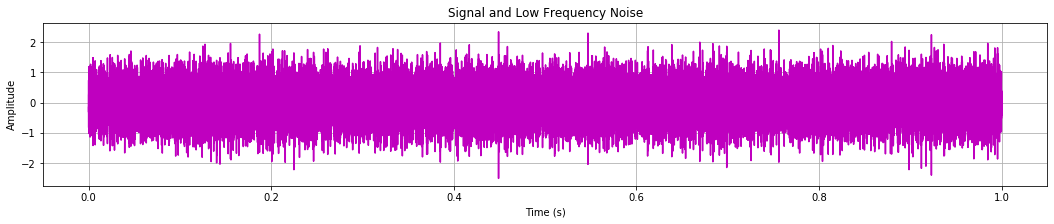

In [71]:
myplot(time, ynoisy, title='Signal and Low Frequency Noise',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(ynoisy,rate=sr)

- - -

<div class="solucao alert alert-success">
$Remez$
</div>

- - -

#### Filter Design

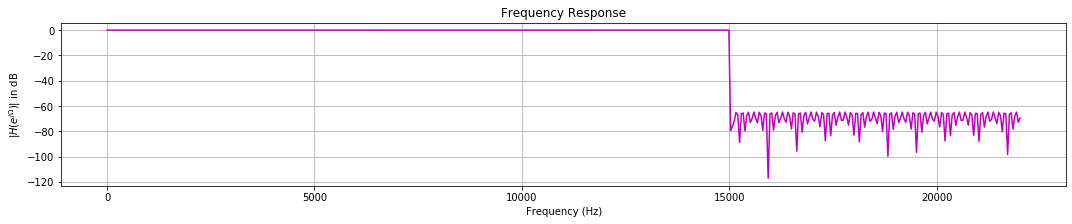

In [72]:
# design (crudely) the denoising filter 
ripple, width = 10, 0.8/(sr/2); numstaps, beta = signal.kaiserord(ripple, width)
edges = np.array([0, fc1 , fc2 - 30, fs/2]) # the cutoff frequency

# design (crudely) the denoising filter 
HPF_remez = signal.remez(numstaps,edges/sr,[1.0,0.0],type='bandpass')


# actually filter the noise 
y_HPF_remez_denoised = np.convolve(HPF_remez,ynoisy)

# (take group delay into account)
y_HPF_remez_denoised = y_HPF_remez_denoised[2750:y.size+2750:]

# plot the response of the filter
w_HPF_remez, H_HPF_remez = signal.freqz(HPF_remez)

# Plot
myplot(w_HPF_remez/(2*np.pi)*sr, 20*np.log10(np.abs(H_HPF_remez)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

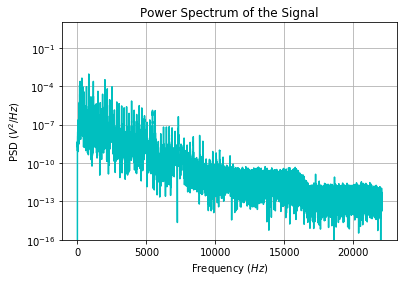

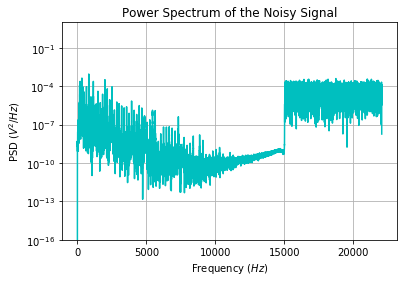

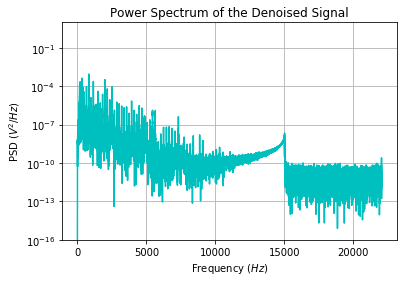

Power of y =  25.820541327492048 dB
SNR before denoising =  -15.657676649927541 dB
SNR after denoising =  -3.110165436777356 dB


In [73]:
SNR_HPF_remez = myspectre(sr, y, ynoisy, y_HPF_remez_denoised)

#### Denoised Signal

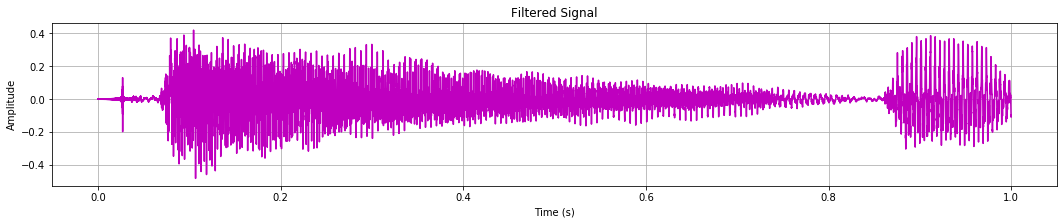

In [74]:
myplot(time, y_HPF_remez_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_HPF_remez_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Kaiser$
</div>

- - -

#### Filter Design

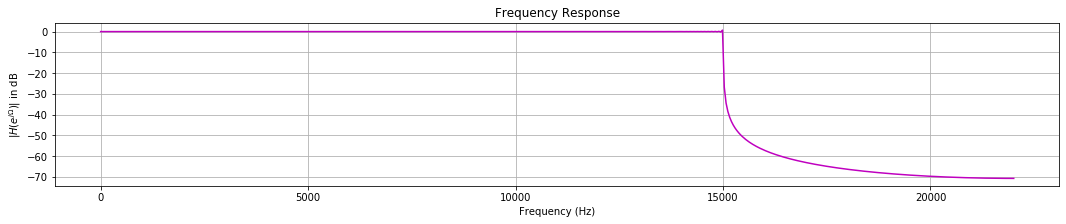

In [75]:
# design (crudely) the denoising filter 
ripple = 9; width = 1.05/(sr/2); numstaps, beta = signal.kaiserord(ripple, width);
HPF_kaiser = signal.firwin(numstaps, fc1, window=('kaiser', beta),
                                        pass_zero=True,scale=False, nyq=fs/2)

# actually filter the noise 
y_HPF_kaiser_denoised = np.convolve(HPF_kaiser,ynoisy)

# (take group delay into account)
y_HPF_kaiser_denoised = y_HPF_kaiser_denoised[2750:y.size+2750:]
    
# Plot
w_HPF_kaiser, H_HPF_kaiser = signal.freqz(HPF_kaiser)
myplot(w_HPF_kaiser/(2*np.pi)*sr, 20*np.log10(np.abs(H_HPF_kaiser)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

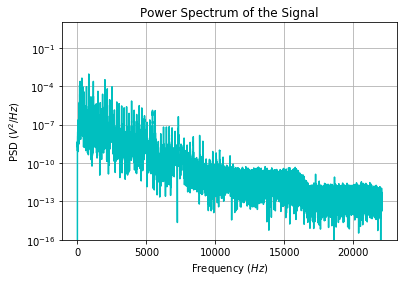

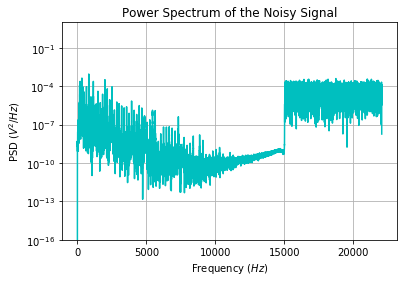

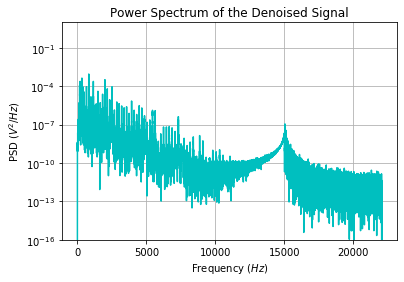

Power of y =  25.820541327492048 dB
SNR before denoising =  -15.657676649927541 dB
SNR after denoising =  -2.8089790226000004 dB


In [76]:
SNR_HPF_kaiser = myspectre(sr, y, ynoisy, y_HPF_kaiser_denoised)

#### Denoised Signal

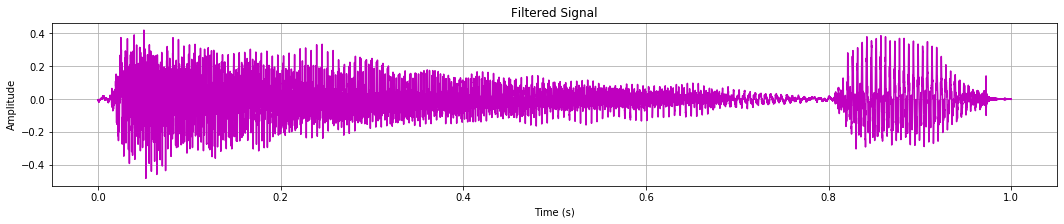

In [77]:
myplot(time, y_HPF_kaiser_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_HPF_kaiser_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Elliptic$
</div>

- - -

#### Filter Design

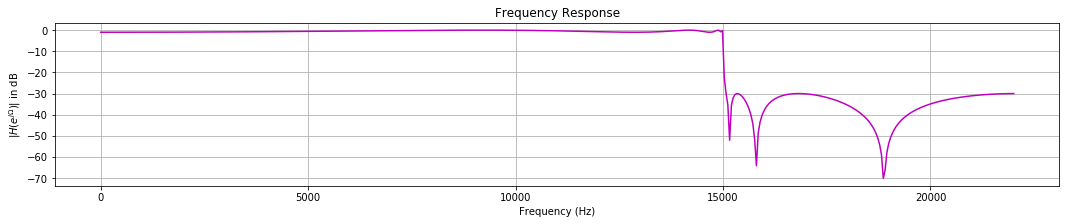

In [78]:
# design (crudely) the denoising filter 
#fc1, fc2 = 880, 910 # cutoff frequency
ws, wp = fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 30 # parameters ripple and attenuation

b_HPF_elliptic, a_HPF_elliptic = signal.iirdesign(wp, ws, gpass, gstop, ftype='ellip')

# actually filter the noise 
y_HPF_elliptic_denoised = signal.filtfilt(b_HPF_elliptic,a_HPF_elliptic, ynoisy)
    
# Plot
w_HPF_elliptic, H_HPF_elliptic = signal.freqz(b_HPF_elliptic, a_HPF_elliptic)
myplot(w_HPF_elliptic/(2*np.pi)*sr, 20*np.log10(np.abs(H_HPF_elliptic)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

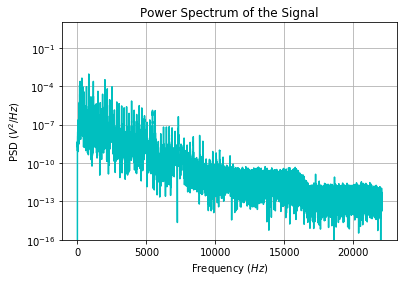

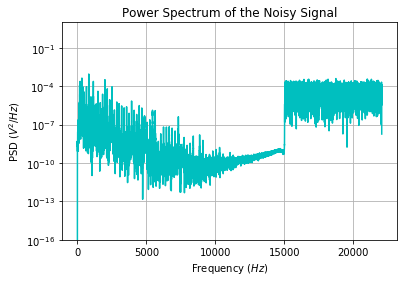

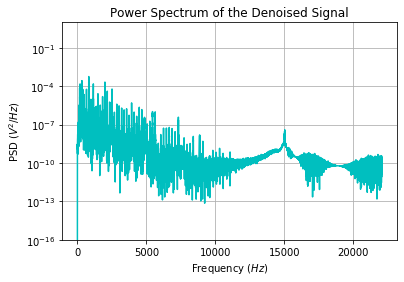

Power of y =  25.820541327492048 dB
SNR before denoising =  -15.657676649927541 dB
SNR after denoising =  13.866252936894757 dB


In [79]:
SNR_HPF_elliptic = myspectre(sr, y, ynoisy, y_HPF_elliptic_denoised)

#### Poles and Zeros Diagram

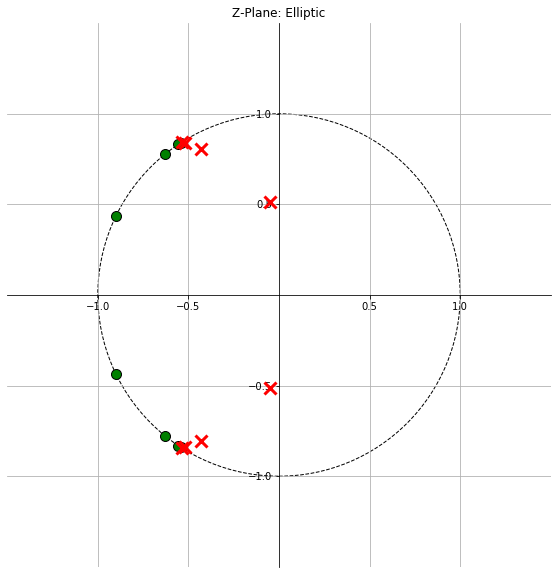

In [80]:
zplane(b_HPF_elliptic, a_HPF_elliptic, title='Z-Plane: Elliptic')

#### Denoised Signal

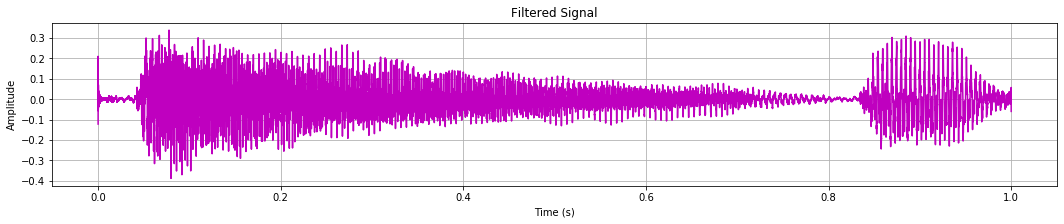

In [81]:
myplot(time, y_HPF_elliptic_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_HPF_elliptic_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Cheby1$
</div>

- - -

#### Filter Design

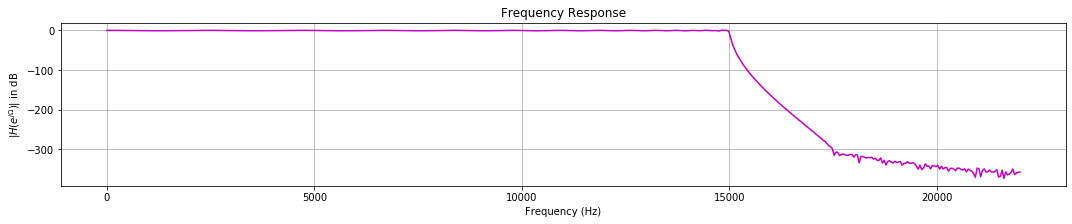

In [82]:
# design (crudely) the denoising filter 
#fc1, fc2 = 880, 910 # cutoff frequency

# Adaptation band width - to the cutoff frequency
ws, wp = 1.001*fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 30 # parameters ripple and attenuation

b_HPF_cheby1, a_HPF_cheby1 = signal.iirdesign(wp, ws, gpass, gstop, ftype='cheby1')

# actually filter the noise 
y_HPF_cheby1_denoised = signal.filtfilt(b_HPF_cheby1,a_HPF_cheby1, ynoisy)
    
# Plot
w_HPF_cheby1, H_HPF_cheby1 = signal.freqz(b_HPF_cheby1, a_HPF_cheby1)
myplot(w_HPF_cheby1/(2*np.pi)*sr, 20*np.log10(np.abs(H_HPF_cheby1)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

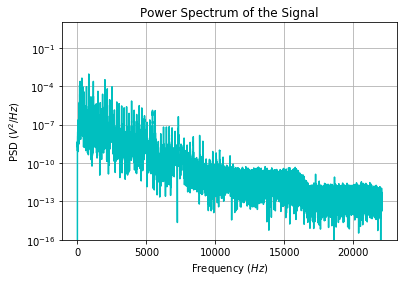

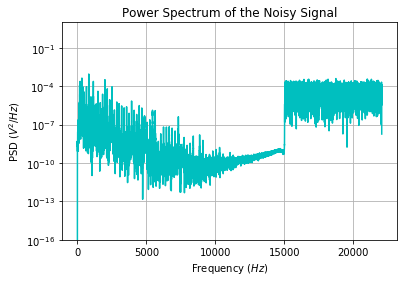

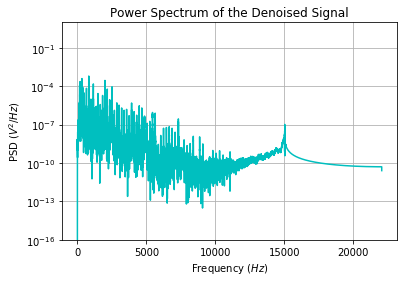

Power of y =  25.820541327492048 dB
SNR before denoising =  -15.657676649927541 dB
SNR after denoising =  18.821580488942125 dB


In [83]:
SNR_HPF_cheby1 = myspectre(sr, y, ynoisy, y_HPF_cheby1_denoised)

#### Poles and Zeros Diagram

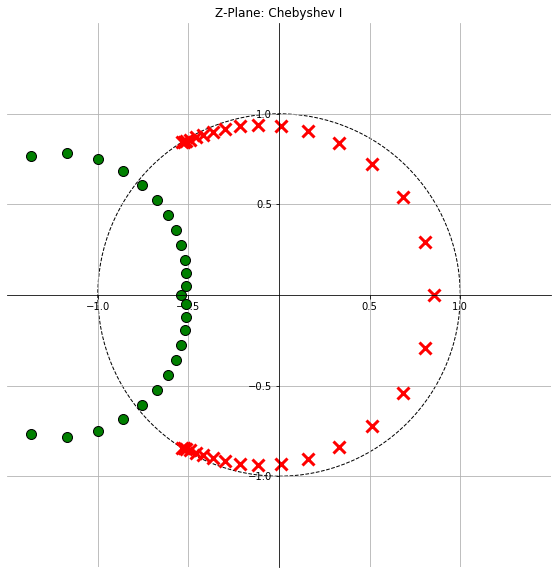

In [84]:
zplane(b_HPF_cheby1,a_HPF_cheby1, title='Z-Plane: Chebyshev I')

#### Denoised Signal

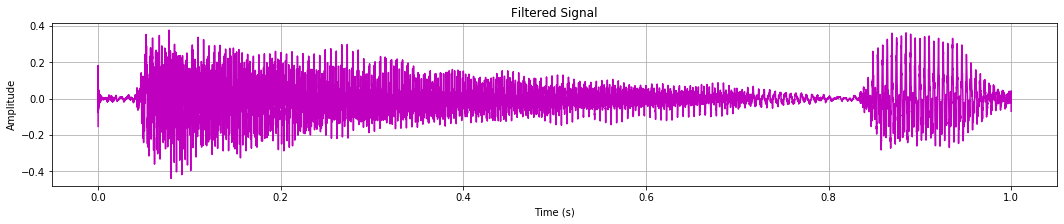

In [85]:
myplot(time, y_HPF_cheby1_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_HPF_cheby1_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Cheby2$
</div>

- - -

#### Filter Design

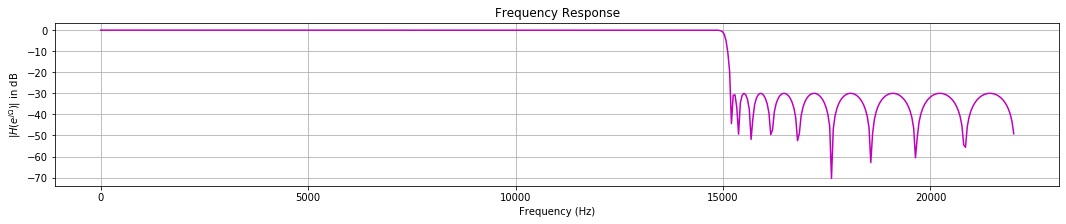

In [86]:
# design (crudely) the denoising filter 
# Adaptation band width - to the cutoff frequency
ws, wp = 1.01*fc2/(sr/2), fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 30 # parameters ripple and attenuation

b_HPF_cheby2, a_HPF_cheby2 = signal.iirdesign(wp, ws, gpass, gstop, ftype='cheby2')

# actually filter the noise 
y_HPF_cheby2_denoised = signal.filtfilt(b_HPF_cheby2,a_HPF_cheby2, ynoisy)
    
# Plot
w_HPF_cheby2, H_HPF_cheby2 = signal.freqz(b_HPF_cheby2, a_HPF_cheby2)
myplot(w_HPF_cheby2/(2*np.pi)*sr, 20*np.log10(np.abs(H_HPF_cheby2)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

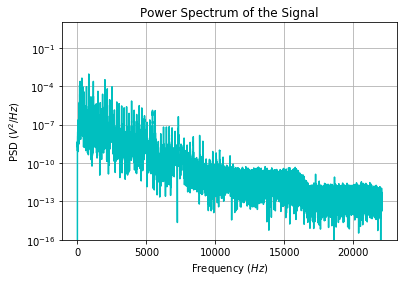

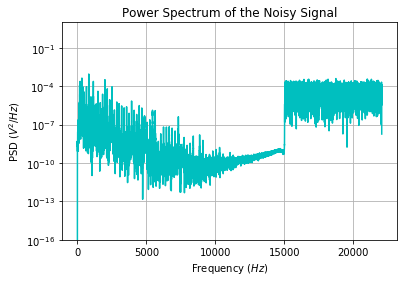

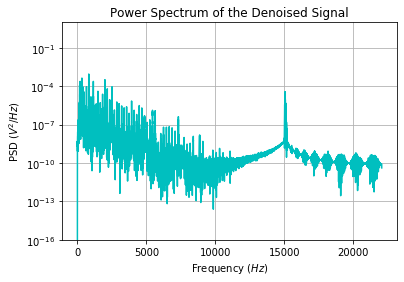

Power of y =  25.820541327492048 dB
SNR before denoising =  -15.657676649927541 dB
SNR after denoising =  11.801914734045232 dB


In [87]:
SNR_HPF_cheby2 = myspectre(sr, y, ynoisy, y_HPF_cheby2_denoised)

#### Poles and Zeros Diagram

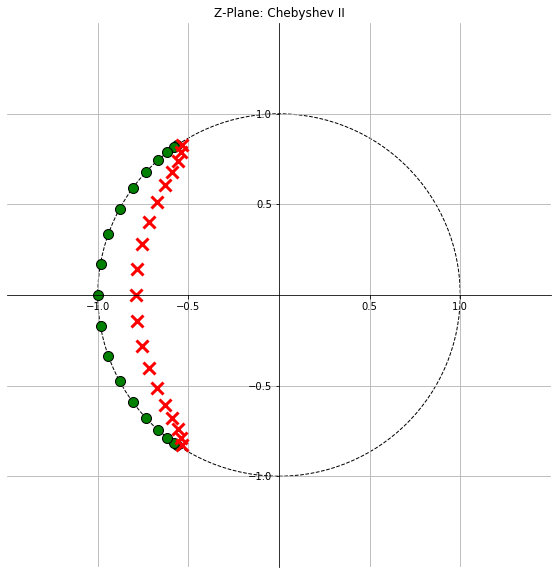

In [88]:
zplane(b_HPF_cheby2,a_HPF_cheby2, title='Z-Plane: Chebyshev II')

#### Denoised Signal

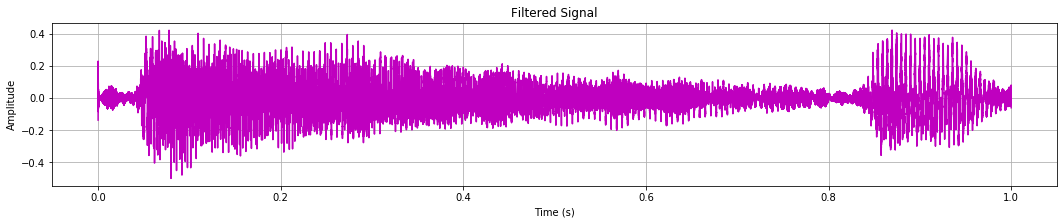

In [89]:
myplot(time, y_HPF_cheby2_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_HPF_cheby2_denoised,rate=sr)

- - -

<div class="solucao alert alert-success">
$Butterworth$
</div>

- - -

#### Filter Design

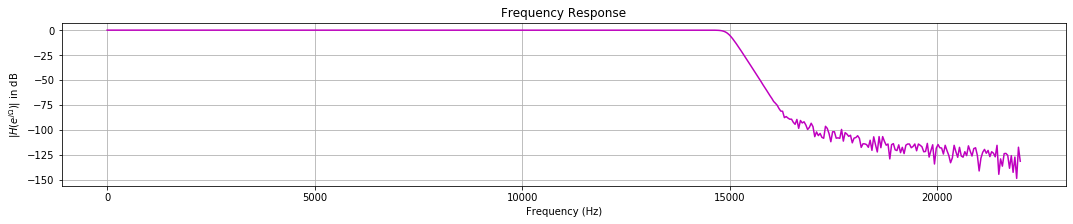

In [90]:
# design (crudely) the denoising filter 
# Adaptation band width - to the cutoff frequency
ws, wp = 1.025*fc2/(sr/2), 0.99*fc1/(sr/2) # normalized cutoff frequency
gpass, gstop= 1, 30 # parameters ripple and attenuation

b_HPF_butter, a_HPF_butter = signal.iirdesign(wp, ws, gpass, gstop, ftype='butter')

# actually filter the noise 
y_HPF_butter_denoised = signal.filtfilt(b_HPF_butter,a_HPF_butter, ynoisy)
    
# Plot
w_HPF_butter, H_HPF_butter = signal.freqz(b_HPF_butter, a_HPF_butter)
myplot(w_HPF_butter/(2*np.pi)*sr, 20*np.log10(np.abs(H_HPF_butter)), 
       title='Frequency Response',x_axis='Frequency (Hz)', y_axis='$|H(e^{j \Omega})|$ in dB');

#### PSD Plot and SNR

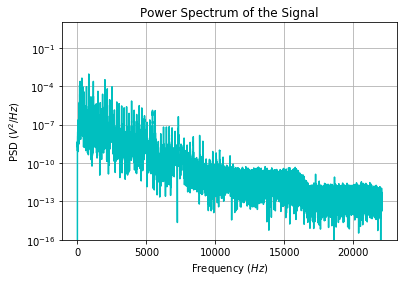

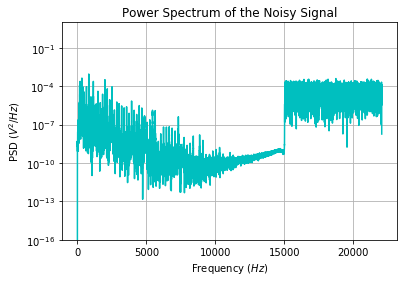

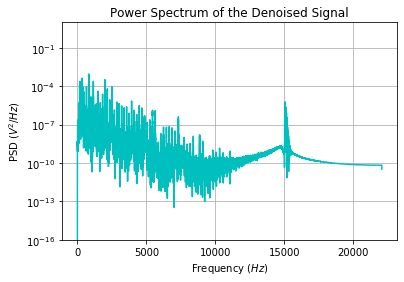

Power of y =  25.820541327492048 dB
SNR before denoising =  -15.657676649927541 dB
SNR after denoising =  18.76614332050198 dB


In [91]:
SNR_HPF_butter = myspectre(sr, y, ynoisy, y_HPF_butter_denoised)

#### Denoised Signal

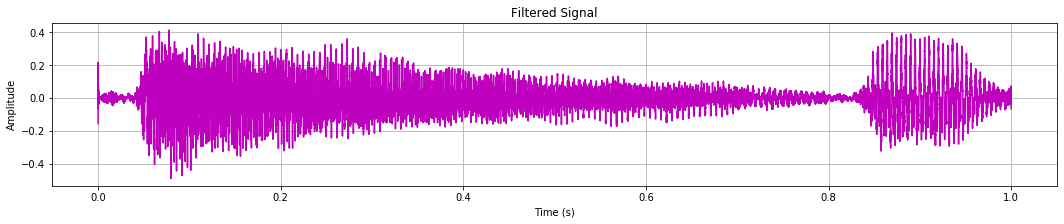

In [92]:
myplot(time, y_HPF_butter_denoised, title='Filtered Signal',x_axis='Time (s)', y_axis='Amplitude');

ipd.Audio(y_HPF_butter_denoised,rate=sr)

- - -

- - -
### SNR (dB)

In [93]:
import pandas as pd
data = [ ['LPF', round(SNR_LPF_remez,2), round(SNR_LPF_kaiser,2), round(SNR_LPF_elliptic,2), 
         round(SNR_LPF_cheby1,2), round(SNR_LPF_cheby2,2), round(SNR_LPF_butter,2)], 
        ['BPF', round(SNR_BPF_remez,2), round(SNR_BPF_kaiser,2), round(SNR_BPF_elliptic,2), 
         round(SNR_BPF_cheby1,2), round(SNR_BPF_cheby2,2), round(SNR_BPF_butter,2)], 
        ['HPF', round(SNR_HPF_remez,2), round(SNR_HPF_kaiser,2), round(SNR_HPF_elliptic,2), 
         round(SNR_HPF_cheby1,2), round(SNR_HPF_cheby2,2), round(SNR_HPF_butter,2)] ]

pd.DataFrame(data, columns=["Filter", "Remez", "Kaiser", "Elliptiques", "Chebyshev I", "Chebyshev II",
                            "Butterworth"])

Filter  Remez  Kaiser  Elliptiques  Chebyshev I  Chebyshev II  Butterworth
0    LPF  -1.86   -0.36         1.47        -3.07          1.51         1.39
1    BPF  -3.16   -2.95        13.67        15.91         23.16        15.91
2    HPF  -3.11   -2.81        13.87        18.82         11.80        18.77

# Conclusion

### Low Pass Filter
    The IIR filters need a larger band width for the transistion of the cutoff frequency. So, if you have a short transition, maybe the FIR works better. But, in this case the Elliptique and Cheb2 fitted better and you can even see the result of how well it worked on the time domain, that the filtered signal its seems closer to the original piano.
    
### Pass Band Filter
    The width of the cutoff transition implies also in better quality and atenuation on the desired window. But, in this case the Cheb2 worked better and you can even on the time domain, that the filtered signal its seems closer to the original piano. In this case, we obtain the closest SNR in comparaison with the original.
    
### High Pass Filter
    For this case, the difference of performance between FIR and IIR still the same as Pass Band case. ChebI and Butterworth have similar results and delivery SNR good enough.